# CHURN

# Imports

In [1337]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import shap

import pickle


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import GridSearchCV

import pickle

# quitar alertas
import warnings
warnings.filterwarnings("ignore")

# Business Understanding​

In [1338]:
df = pd.read_csv('data/churn - dataset a entrenar.csv')
df_pred = pd.read_csv('data/churn - dataset a predecir.csv')
df_variables = pd.read_csv('data/churn - diccionario de variables.csv')

In [1339]:
df.head()

rev      mou  totmrc  ovrmou  ovrrev  vceovr  roam  change_mou  \
0  23.9975   219.25   22.50     0.0     0.0     0.0   0.0     -157.25   
1  55.2300   570.50   71.98     0.0     0.0     0.0   0.0       38.50   
2  82.2750  1312.25   75.00     0.0     0.0     0.0   0.0      156.75   
3  17.1450     0.00   16.99     0.0     0.0     0.0   0.0        0.00   
4  38.0525   682.50   52.49     0.0     0.0     0.0   0.0      147.50   

   change_rev   drop_vce  ...  forgntvl  ethnic  kid0_2  kid3_5  kid6_10  \
0    -18.9975   0.666667  ...       0.0       N       U       U        U   
1      0.0000   9.666667  ...       0.0       I       U       U        U   
2      8.1450  52.000000  ...       0.0       U       U       U        U   
3     -0.1550   0.000000  ...       0.0       N       U       U        U   
4     -3.0625   9.000000  ...       1.0       S       U       U        U   

   kid11_15  kid16_17  creditcd  eqpdays  Customer_ID  
0         U         U         Y    361.0      1000001  
1         U         U         Y    434.0      1000005  
2         U         U         Y    458.0      1000006  
3         U         U         Y    852.0      1000007  
4         U         U         Y    231.0      1000008  

[5 rows x 86 columns]

In [1340]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 86 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rev               50000 non-null  float64
 1   mou               50000 non-null  float64
 2   totmrc            50000 non-null  float64
 3   ovrmou            50000 non-null  float64
 4   ovrrev            50000 non-null  float64
 5   vceovr            50000 non-null  float64
 6   roam              50000 non-null  float64
 7   change_mou        50000 non-null  float64
 8   change_rev        50000 non-null  float64
 9   drop_vce          50000 non-null  float64
 10  blck_vce          50000 non-null  float64
 11  blck_dat          50000 non-null  float64
 12  unan_vce          50000 non-null  float64
 13  plcd_vce          50000 non-null  float64
 14  recv_vce          50000 non-null  float64
 15  comp_vce          50000 non-null  float64
 16  comp_dat          50000 non-null  float6

In [1341]:
df_describe = df.describe()
min_values = df_describe[df_describe.index=='min'].T
negative_values = min_values[min_values['min']<0]
negative_values

min
totmrc       -26.915
change_mou -3406.500
change_rev -1107.740
avg6rev       -2.000
eqpdays       -5.000

In [1342]:
df_describe

rev           mou        totmrc        ovrmou        ovrrev  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean      59.592453    525.927840     46.757288     42.251626     13.682811   
std       49.442525    541.537185     24.141474    102.904894     31.589805   
min        0.885000      0.000000    -26.915000      0.000000      0.000000   
25%       33.250000    155.500000     30.000000      0.000000      0.000000   
50%       48.186250    361.750000     44.990000      2.500000      0.875000   
75%       71.578125    719.250000     59.990000     41.250000     13.900000   
max     3843.262500  12206.750000    409.990000   4320.750000    890.762500   

             vceovr          roam    change_mou    change_rev      drop_vce  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean      13.423204      1.384443    -14.118840     -1.280641      6.045740   
std       31.226904     19.091658    292.666852     59.347247      9.179373   
min        0.000000      0.000000  -3406.500000  -1107.740000      0.000000   
25%        0.000000      0.000000    -85.500000     -7.320000      0.666667   
50%        0.483750      0.000000     -6.250000     -0.315000      3.000000   
75%       13.500000      0.257500     62.750000      1.480000      7.666667   
max      890.762500   3685.200000  31219.250000   9963.657500    232.666667   

       ...        phones        models         truck           rv  \
count  ...  50000.000000  50000.000000  50000.000000  50000.00000   
mean   ...      1.866500      1.600760      0.198920      0.08816   
std    ...      1.386289      0.937307      0.399192      0.28353   
min    ...      1.000000      1.000000      0.000000      0.00000   
25%    ...      1.000000      1.000000      0.000000      0.00000   
50%    ...      1.000000      1.000000      0.000000      0.00000   
75%    ...      2.000000      2.000000      0.000000      0.00000   
max    ...     24.000000     15.000000      1.000000      1.00000   

                lor        income      numbcars      forgntvl       eqpdays  \
count  36287.000000  38688.000000  26519.000000  50000.000000  50000.000000   
mean       6.259184      5.804513      1.568724      0.060240    390.685960   
std        4.762210      2.189491      0.631659      0.237933    251.122428   
min        0.000000      1.000000      1.000000      0.000000     -5.000000   
25%        2.000000      4.000000      1.000000      0.000000    218.000000   
50%        5.000000      6.000000      1.000000      0.000000    349.000000   
75%       10.000000      7.000000      2.000000      0.000000    530.000000   
max       15.000000      9.000000      3.000000      1.000000   1698.000000   

        Customer_ID  
count  5.000000e+04  
mean   1.044602e+06  
std    2.608113e+04  
min    1.000001e+06  
25%    1.022040e+06  
50%    1.044464e+06  
75%    1.067373e+06  
max    1.089997e+06  

[8 rows x 69 columns]

### Valores negativos sin sentido:
#### totmrc: Mean total monthly recurring charge
#### avg6rev: Average monthly revenue over the previous six months
#### eqpdays: Number of days (age) of current equipment
 
 
 

In [1343]:
# totmrc
df[df['totmrc']<0]

rev     mou   totmrc  ovrmou   ovrrev  vceovr     roam  change_mou  \
12840  49.3000   77.00  -0.2400   44.50  44.5000  44.500   0.0000      -77.00   
22462  45.8100  814.75  -0.2825  108.75  42.1000  42.100   0.0000       90.25   
23311   4.5250  136.75  -0.2700   10.75   4.3000   4.300   0.0000       -6.75   
26883  42.2200  121.75  -5.7250   26.75  26.7500  26.750  20.9100      106.25   
29602  49.4500    0.00 -26.9150    0.00   0.0000   0.000   0.0000        0.00   
29745   7.3175    0.00  -5.2000    0.00   0.0000   0.000   0.0000        0.00   
33826   8.8200    6.50  -0.2400    6.50   6.5000   6.500   0.0000       -6.50   
35796   4.6650  140.25  -0.0825    0.00   0.0000   0.000   0.0000       74.75   
39219   3.5625  156.75  -1.4225    7.00   2.4500   0.875   0.6475     -156.75   
46685  29.7850  530.50  -0.0825   71.50  28.6000  28.600   1.2675     -158.50   
46938   1.2525  214.75  -0.0825    0.25   0.0975   0.000   0.0000       37.25   

       change_rev   drop_vce  ...  forgntvl  ethnic  kid0_2  kid3_5  kid6_10  \
12840    -44.3000   0.000000  ...       1.0       U       U       U        U   
22462     27.0200  11.333333  ...       1.0       H       Y       U        Y   
23311     11.8750   1.000000  ...       0.0       N       U       U        U   
26883     38.1100   2.666667  ...       0.0       U       U       U        U   
29602    -44.4500   0.000000  ...       0.0       Z       U       U        U   
29745      2.6825   0.000000  ...       0.0       N       U       U        U   
33826     -3.8200   0.000000  ...       0.0       H       U       U        U   
35796      0.3250   0.666667  ...       0.0       Z       U       U        U   
39219     -3.5625   1.000000  ...       0.0       I       U       U        U   
46685    -29.7850   3.666667  ...       0.0       N       U       U        U   
46938      0.7275   5.333333  ...       0.0       Z       U       U        U   

       kid11_15  kid16_17  creditcd  eqpdays  Customer_ID  
12840         U         U         Y    324.0      1022622  
22462         U         U         N    131.0      1039872  
23311         U         U         N    641.0      1041421  
26883         U         U         N    275.0      1047873  
29602         U         U         N    212.0      1052787  
29745         U         U         N    365.0      1053056  
33826         U         U         N    318.0      1060597  
35796         U         U         Y    465.0      1064191  
39219         U         U         Y    363.0      1070472  
46685         U         U         N    369.0      1083525  
46938         U         U         Y    119.0      1084072  

[11 rows x 86 columns]

In [1344]:
# avg6rev
df[df['avg6rev']<0]

rev  mou  totmrc  ovrmou  ovrrev  vceovr  roam  change_mou  change_rev  \
34524  5.0  0.0     5.0     0.0     0.0     0.0   0.0         0.0         0.0   

       drop_vce  ...  forgntvl  ethnic  kid0_2  kid3_5  kid6_10  kid11_15  \
34524       0.0  ...       0.0       S       U       U        U         U   

       kid16_17  creditcd  eqpdays  Customer_ID  
34524         U         N    371.0      1061910  

[1 rows x 86 columns]

In [1345]:
# eqpdays
df[df['eqpdays']<0]

rev      mou    totmrc  ovrmou    ovrrev    vceovr     roam  \
855     77.1625   413.25   70.0000    0.00    0.0000    0.0000   1.9200   
2194    45.5100   666.00   44.9900   26.00    9.1000    9.1000   0.3200   
4481    62.1725   838.75   81.0375    0.00    0.0000    0.0000   0.0000   
4985    36.5200   147.75   44.9900    0.00    0.0000    0.0000   0.2925   
5689    76.3900   296.00   29.9900  126.75   46.4000   46.4000   0.0000   
5883   116.2625  2179.25   74.9925   68.50   26.3500   26.3500   0.0000   
8386   111.0625   868.25   75.0000    1.00    0.3900    0.0000   0.5850   
9515    46.4775   463.50   34.9800   37.50   11.2500   11.2500   0.0000   
9977    37.6450   256.00   44.9900    0.00    0.0000    0.0000   0.0000   
11100   57.3550  1502.75   82.9325    0.00    0.0000    0.0000   0.0000   
11319  143.0850  1833.75   76.5625  203.50   50.8750   50.8750   0.0000   
11881   41.6075   274.50   41.6075    0.00    0.0000    0.0000   0.0000   
13666   59.7825   646.00   62.2825    0.00    0.0000    0.0000   0.0000   
14493   85.5450  1049.75   49.9900   80.00   32.0000   32.0000   0.0000   
14645   49.8175   263.25   32.9900    1.50    0.5850    0.0000   0.0000   
15216  107.1925  1451.00   59.9900  140.75   56.3000   56.3000   0.1600   
16745   27.7925   172.25   30.0000    0.75    0.2925    0.0000   0.0000   
17570  136.0700  2093.50  129.9900   77.50   11.6250   11.6250   0.0000   
18233   49.9900   237.50   49.9900    0.00    0.0000    0.0000   0.0000   
18738   53.0400  1426.25   44.9900   48.00   16.8000   16.8000   0.0000   
20220   74.9800     0.00   39.9900    0.00    0.0000    0.0000   0.0000   
21675   46.2000  2279.00   20.0000   32.00    8.0000    8.0000   9.5175   
22202  306.0325  2117.50   59.9900  624.50  249.8000  249.8000   1.7475   
23051   62.7750   606.00   40.0300   18.75    7.5000    7.5000   0.0000   
23729   36.7875   407.50   37.4475   23.50    9.4000    9.4000   0.0000   
23776   52.0750   240.25   36.4450   19.50    7.8000    7.8000   0.0000   
24000  173.2800  1814.75   69.7875  298.50  102.5225  102.4250   0.2925   
27106   51.7175  1505.50   49.9900    2.25    0.8775    0.0000   0.6400   
27857   45.0325   387.50   16.1550   42.00   16.8000   16.8000   0.0000   
28681  113.8950  1580.25   87.4900  109.50   41.7375   41.7375   5.6925   
29516   67.5875   749.25   49.9900    0.50    0.1950    0.0000   1.4550   
33361   53.4875   154.50   59.9900    0.00    0.0000    0.0000   0.0000   
36181   72.2875  1608.25   49.9900    8.00    3.2000    3.2000  16.8575   
38429   58.6150   713.25   49.9900   40.75   16.2275   13.4000   1.1600   
39512   44.3900   243.50   34.9900    0.00    0.0000    0.0000   0.9100   
42221   36.4875     3.00   36.2425    0.00    0.0000    0.0000   0.0000   
45367   62.5850   803.25   59.9900   30.25   12.1000   12.1000   0.0000   
47294   79.0400  1700.50   59.9900   83.50   25.0500   25.0500   0.0000   
47323   80.8775   606.25   46.2800  108.00   37.8500   37.8500   0.0000   
48482   46.0875  1067.25   44.9900   31.00   10.8500   10.8500   0.0000   
48813   69.6675   262.75   37.1675    0.00    0.0000    0.0000   0.0000   
48883   57.5700   298.50   11.6750    0.00    0.0000    0.0000   0.0000   
48887  201.1925  2004.75   44.9925  388.50  155.3975  155.3000   0.0975   
49185  326.0250  4654.25  169.9900  708.25  106.2375  106.2375   0.0000   
49579  243.0175  2149.25  129.3650  375.75  150.3000  150.3000   0.0000   
49631   52.8700  1264.00   54.9900    0.50    0.1950    0.0000   0.0000   

       change_mou  change_rev    drop_vce  ...  forgntvl  ethnic  kid0_2  \
855        208.75     -3.9125    3.000000  ...       0.0       N       U   
2194        35.00     -9.2400   23.333333  ...       0.0       Z       U   
4481       138.25     -3.4925    4.666667  ...       0.0       U       U   
4985      -124.75     -0.3600    0.000000  ...       0.0       N       U   
5689       106.00     18.8000    1.666667  ...       0.0       G       U   
5883      -287.25    -34.0625 

In [1346]:
# ponemos todos los valores en positivo
df['totmrc'] = np.abs(df['totmrc'])
df['avg6rev'] = np.abs(df['avg6rev'])
df['eqpdays'] = np.abs(df['eqpdays'])

## Outliers

<Axes: xlabel='change_mou'>

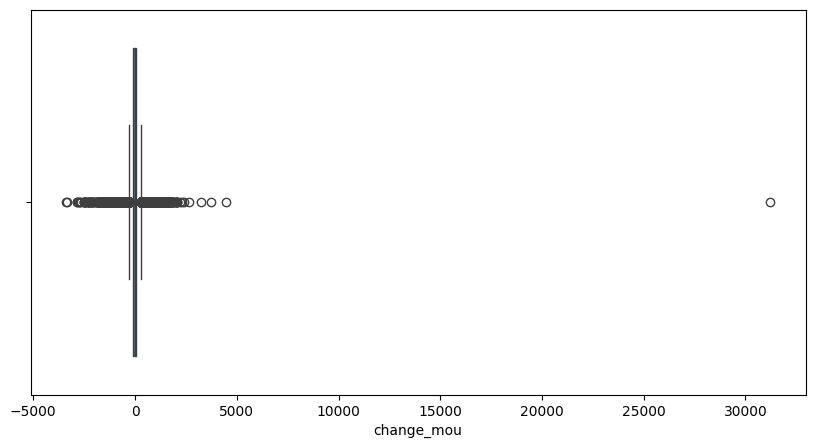

In [1347]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='change_mou')

In [1348]:
df[df['change_mou']>20000][['change_mou','churn']]

change_mou  churn
22089    31219.25      1

#### change_mou (Percentage change in monthly minutes of use vs previous three month average) tiene un impacto negativo para el modelo. Sin embargo, este registro tiene un valor altisimo de change_mou (>30000) y churn = 1. Eliminamos este outlier:

In [1349]:
change_mou_outlier_idx = df[df['change_mou']>20000].index[0]
df.drop(change_mou_outlier_idx, axis=0, inplace=True)

<Axes: xlabel='change_rev'>

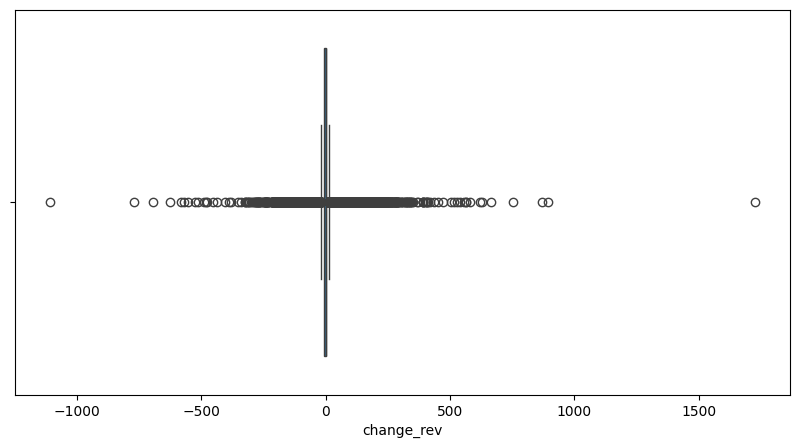

In [1350]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='change_rev')

In [1351]:
df[df['change_rev']>8000][['change_rev','churn']]

Empty DataFrame
Columns: [change_rev, churn]
Index: []

## EDA: Analisis Exploratorio

### Distribución de la target

In [1352]:
target = 'churn'
df[target].value_counts(normalize=True)

churn
0    0.549031
1    0.450969
Name: proportion, dtype: float64

Text(0, 0.5, 'Frecuencia')

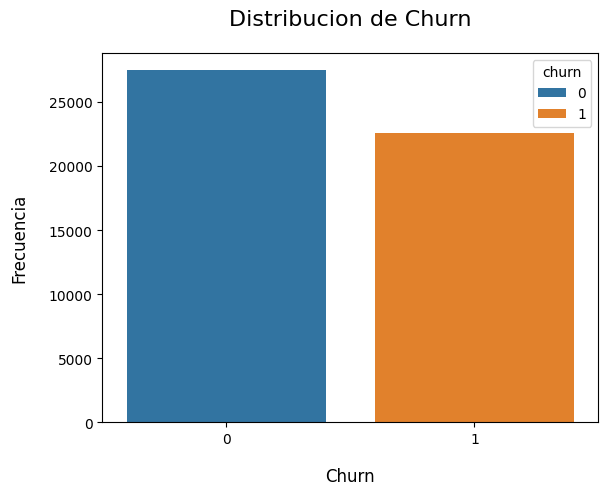

In [1353]:
sns.countplot(data=df, 
              x=df[target], 
              hue=df[target])

plt.title('Distribucion de Churn', pad=20, fontsize=16)
plt.xlabel('Churn', labelpad=15, fontsize=12)
plt.ylabel('Frecuencia', labelpad=15, fontsize=12)

### Analisis univariable

In [1354]:
# funcion para clasificar nuestras variables por tipos
def obtener_lista_variables(dataset):

    lista_numericas=[]
    lista_boolean=[]
    lista_categoricas=[]

    for i in dataset.columns:
        if    (dataset[i].dtype.kind=="f" or dataset[i].dtype.kind=="i") and len(dataset[i].unique())!=2 and (i != target):
              lista_numericas.append(i)
        elif  (dataset[i].dtype.kind=="f" or dataset[i].dtype.kind=="i" or dataset[i].dtype.kind=="b" or dataset[i].dtype.kind=="O") and len(dataset[i].unique())==2 and (i != target):
              lista_boolean.append(i)
        elif  (dataset[i].dtype.kind=="O") and i != target:
              lista_categoricas.append(i)

    return lista_numericas, lista_boolean, lista_categoricas

In [1355]:
lista_numericas, lista_boolean, lista_categoricas = obtener_lista_variables(df)

In [1356]:
print('Variables Numericas:', len(lista_numericas))
print('Variables Booleanes:', len(lista_boolean))
print('Variables Categoricas:', len(lista_categoricas))

print('Total:',len(lista_numericas) + len(lista_boolean) + len(lista_categoricas))

Variables Numericas: 65
Variables Booleanes: 12
Variables Categoricas: 8
Total: 85


In [1357]:
len(df.columns)

86

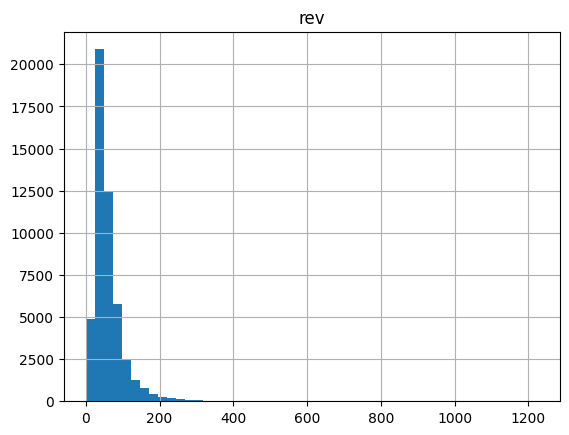

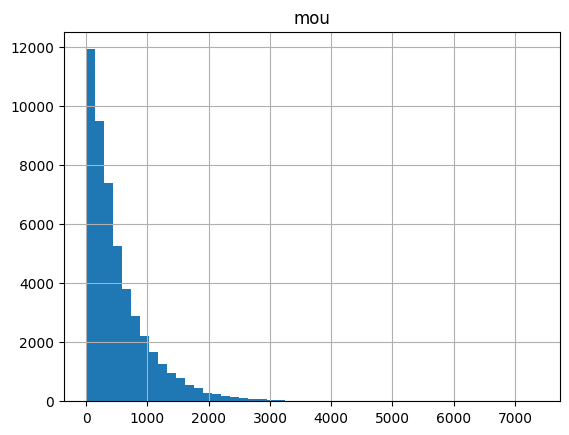

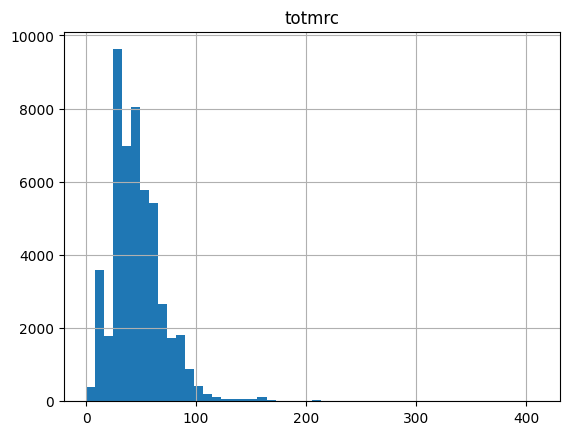

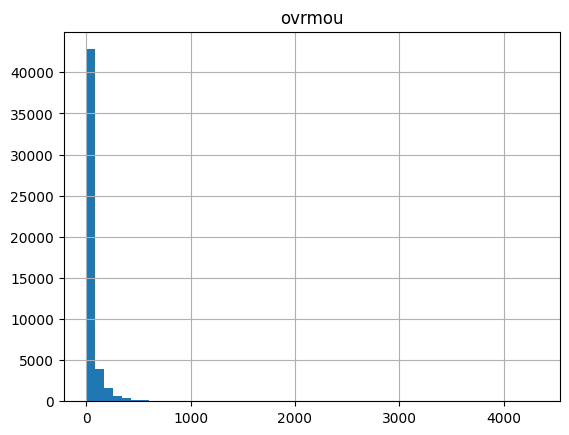

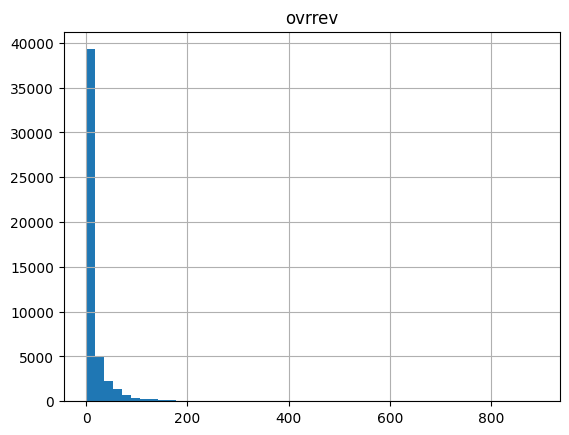

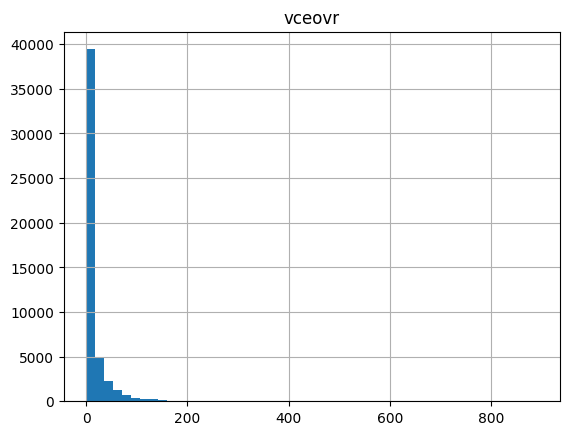

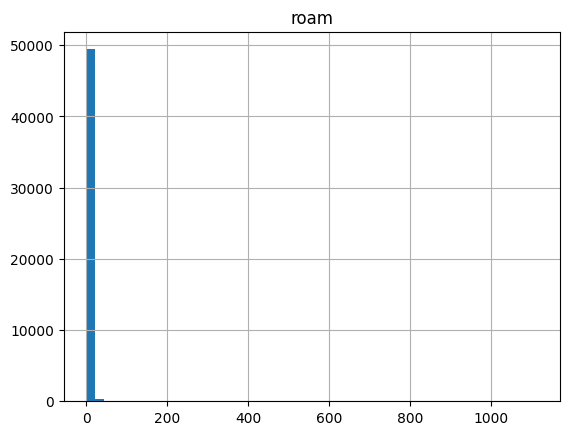

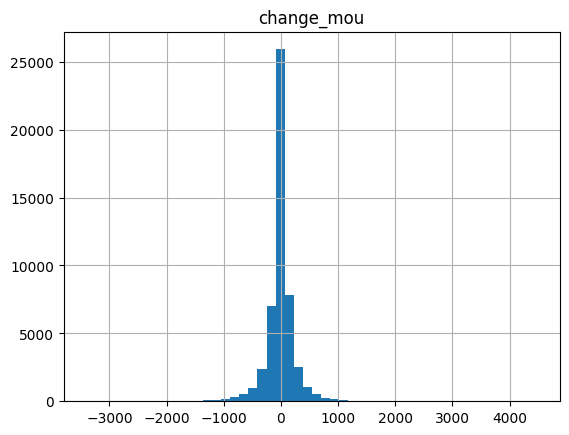

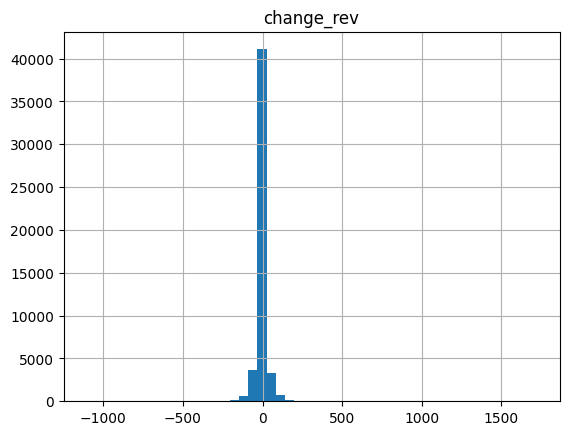

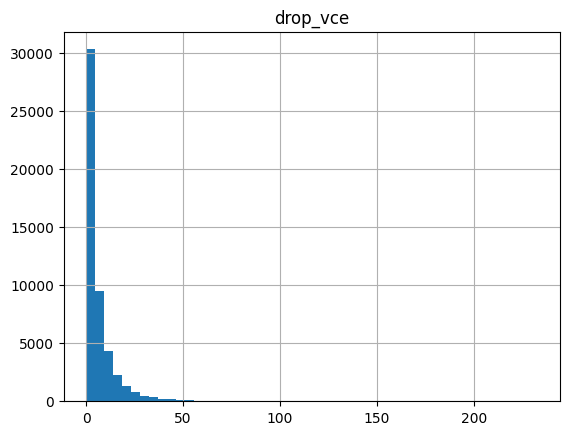

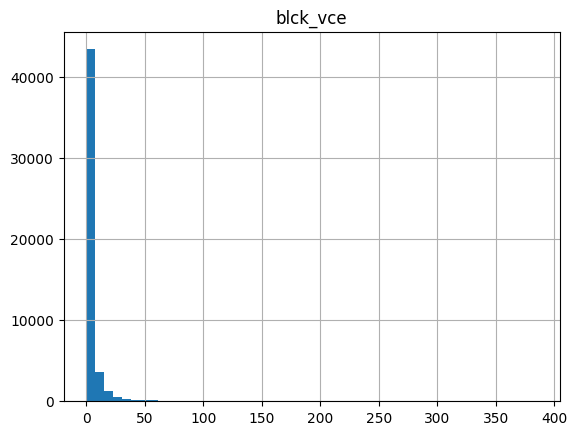

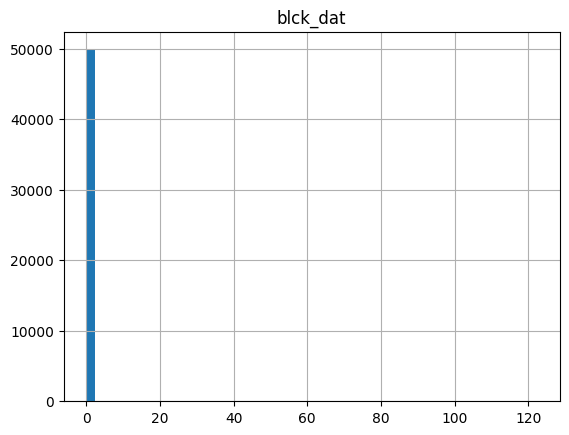

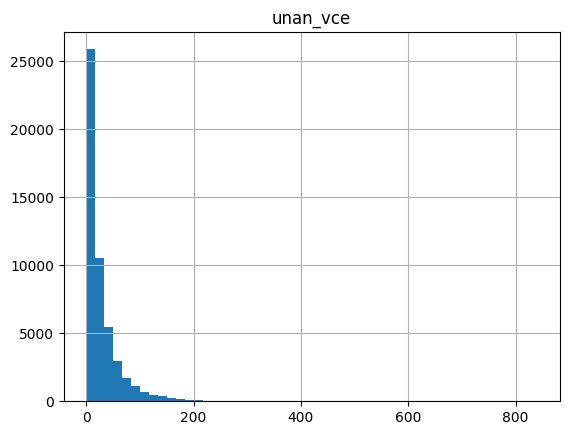

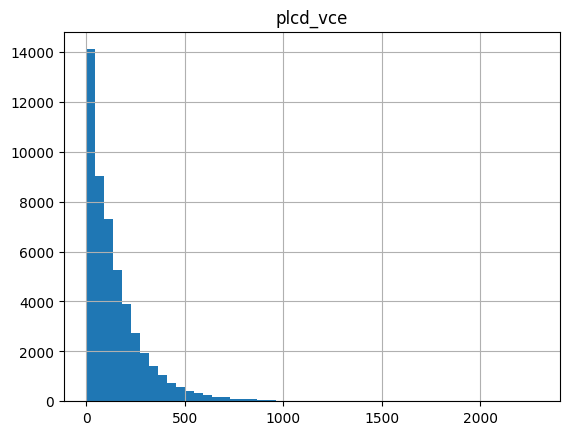

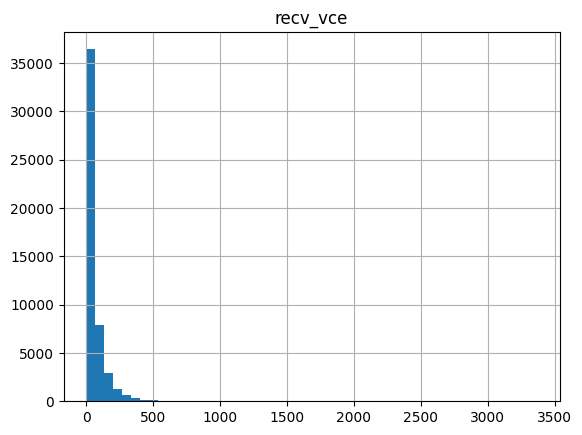

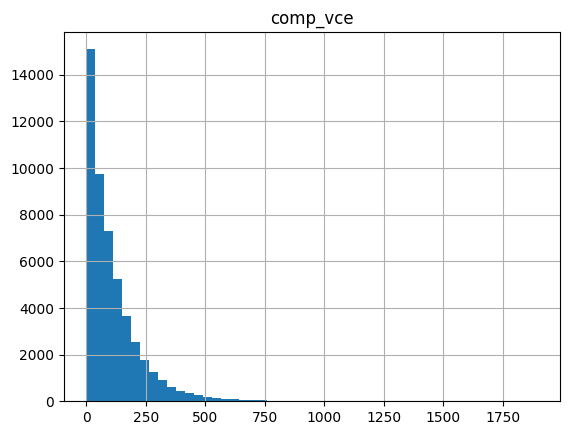

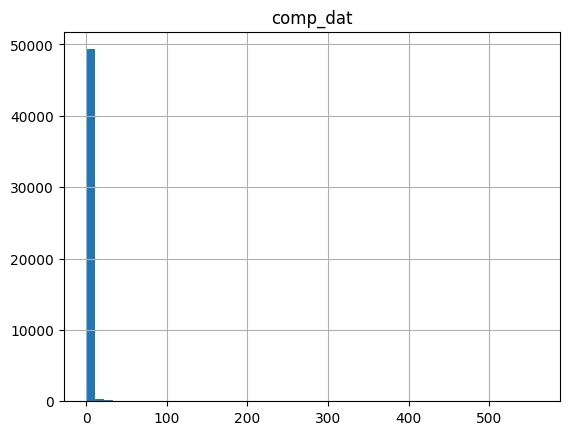

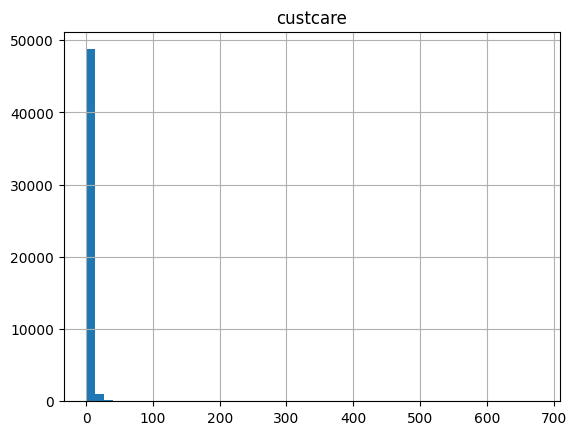

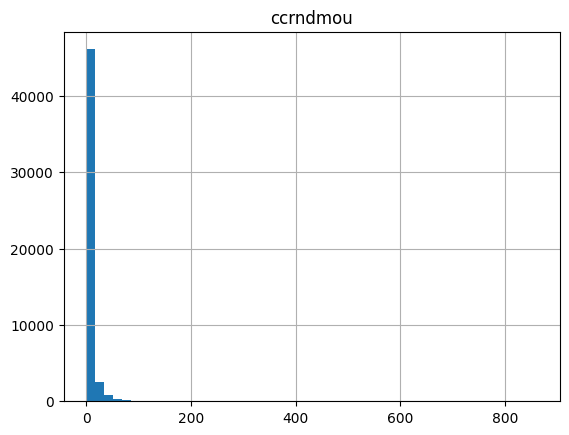

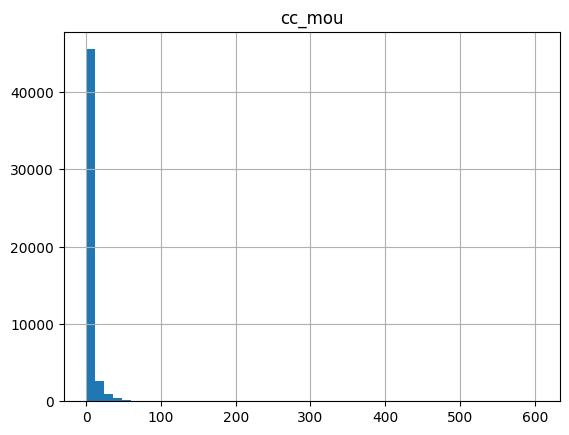

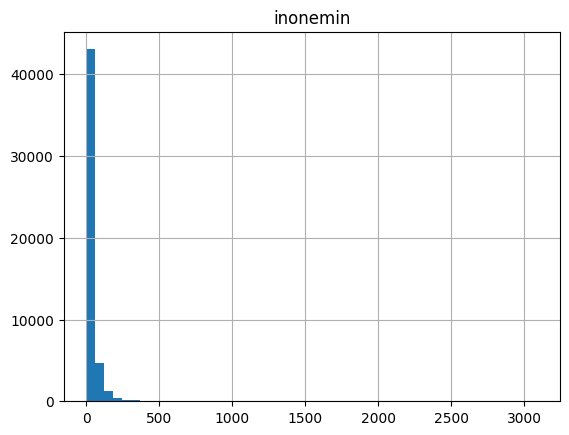

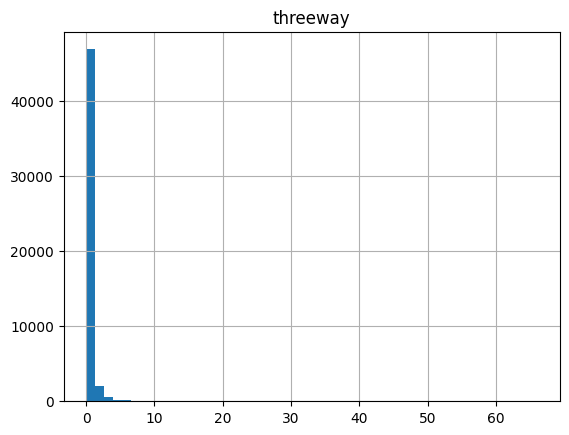

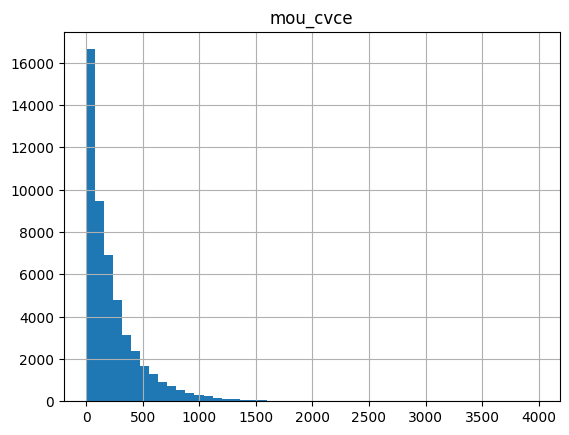

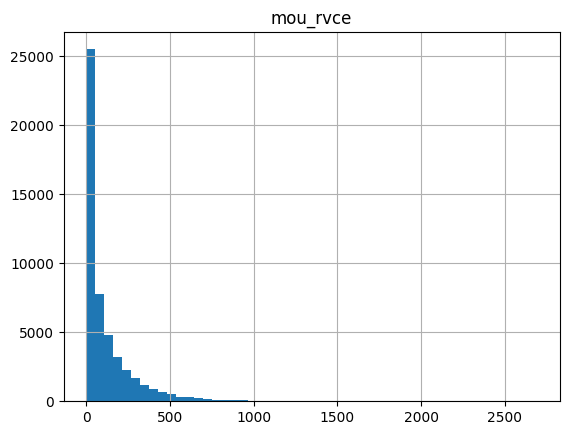

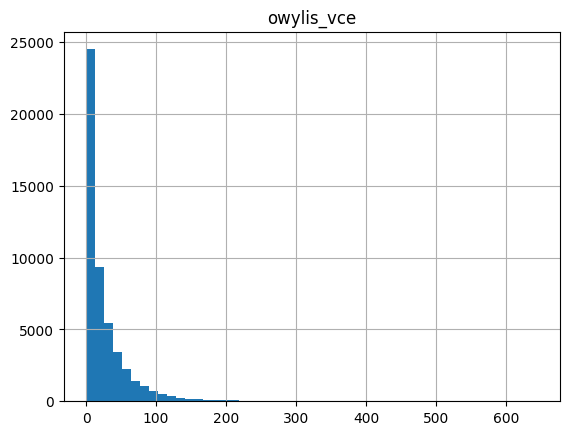

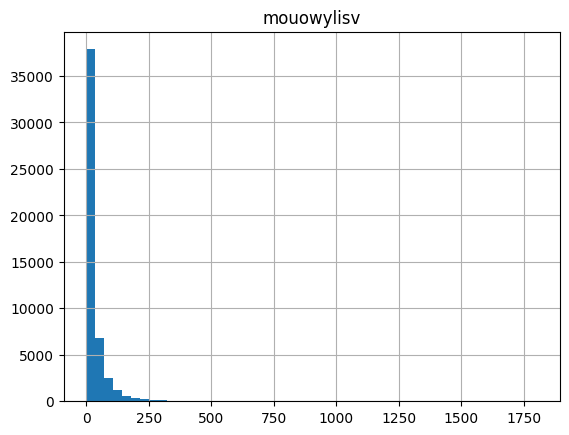

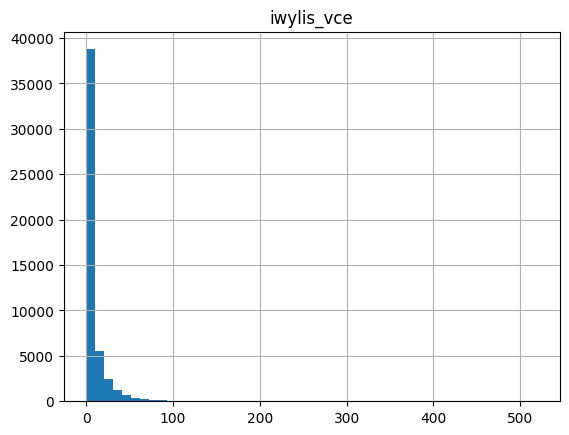

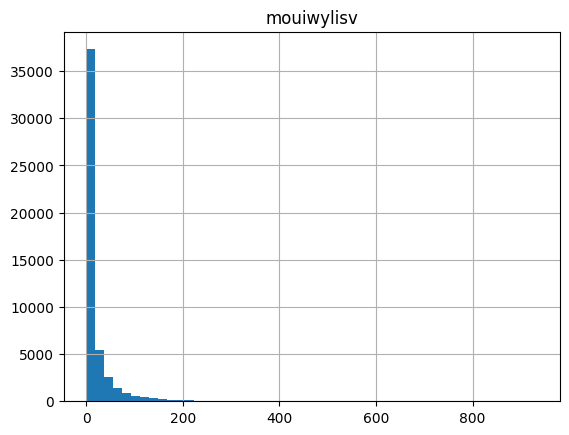

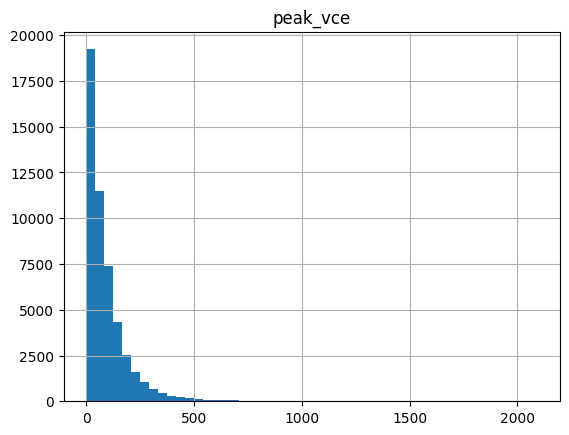

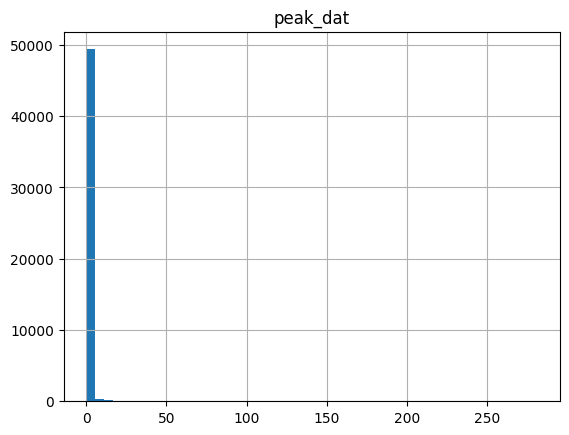

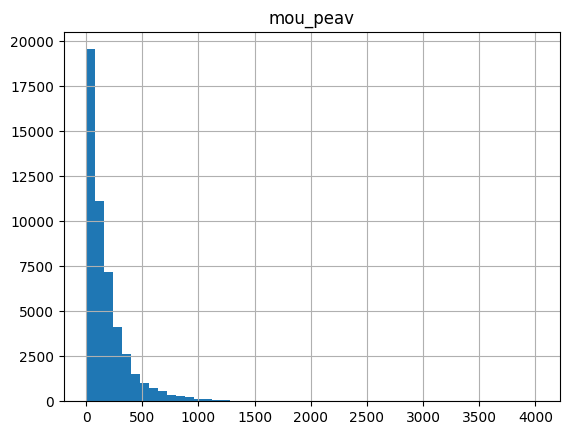

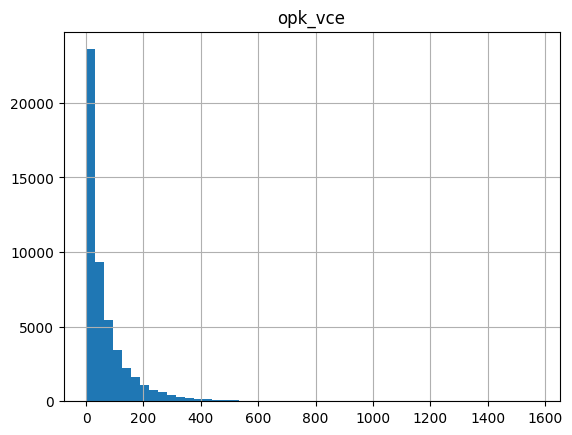

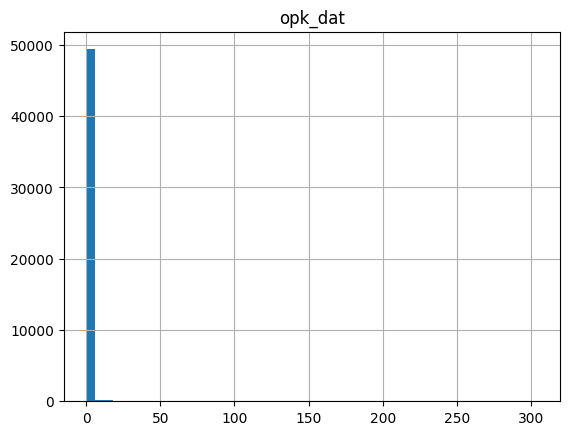

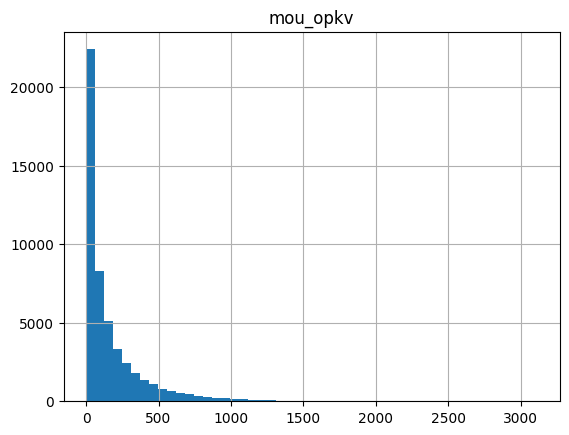

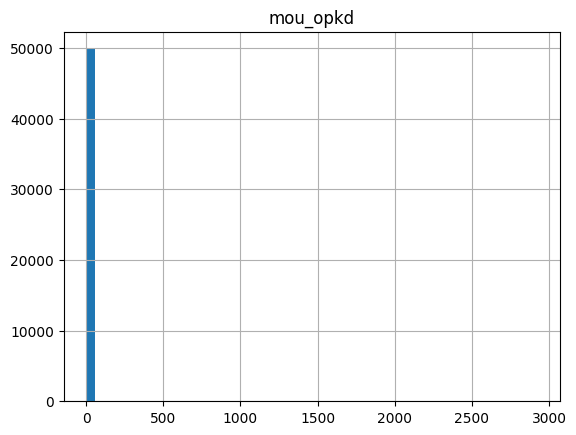

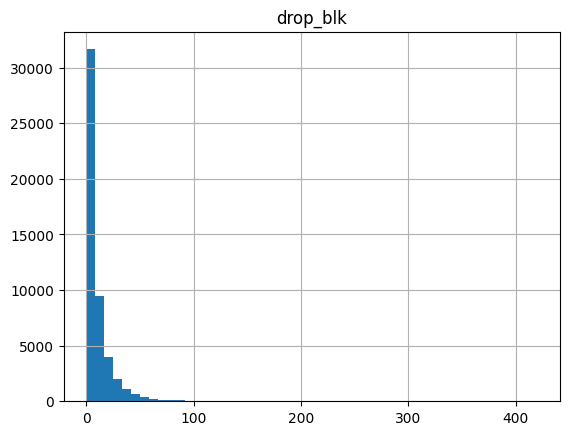

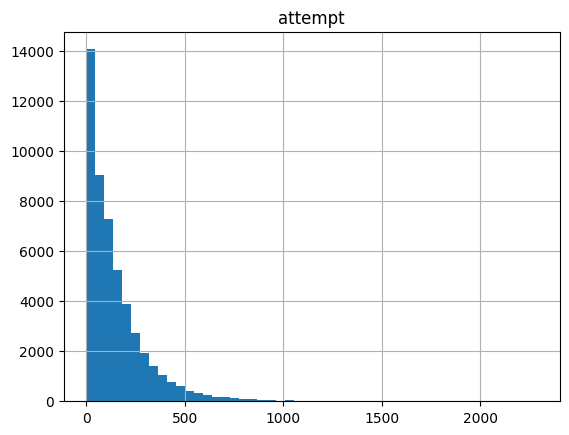

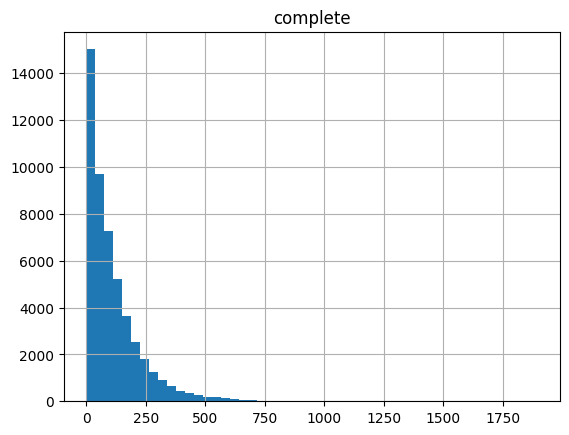

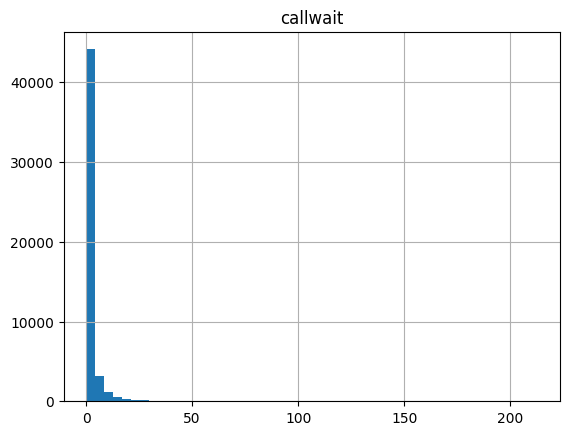

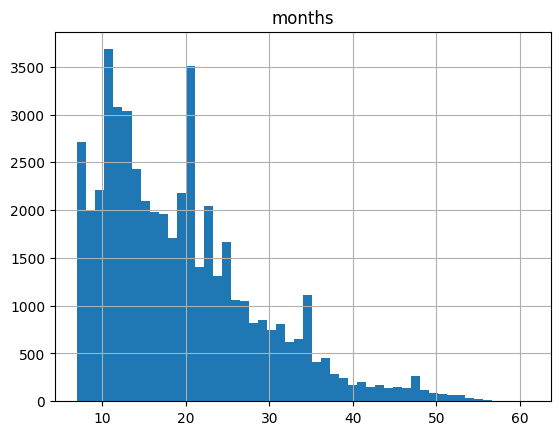

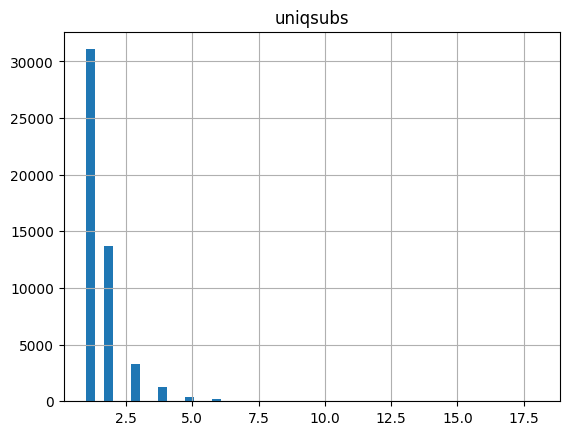

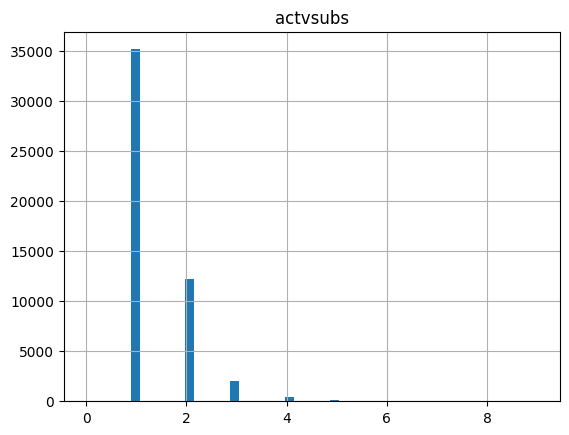

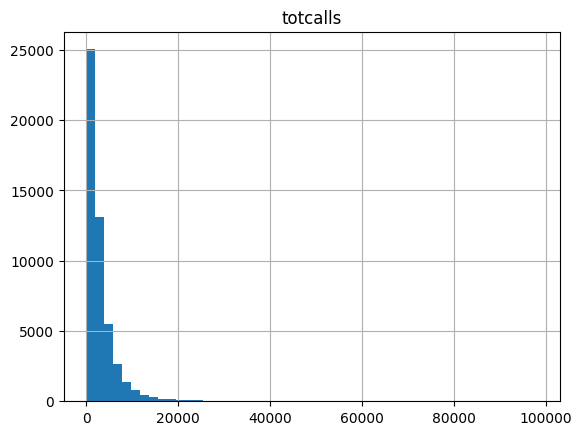

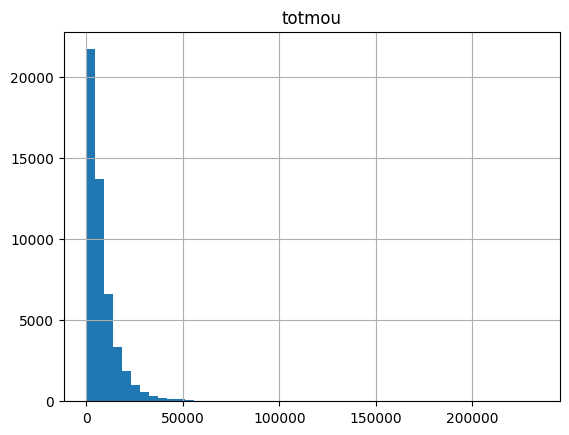

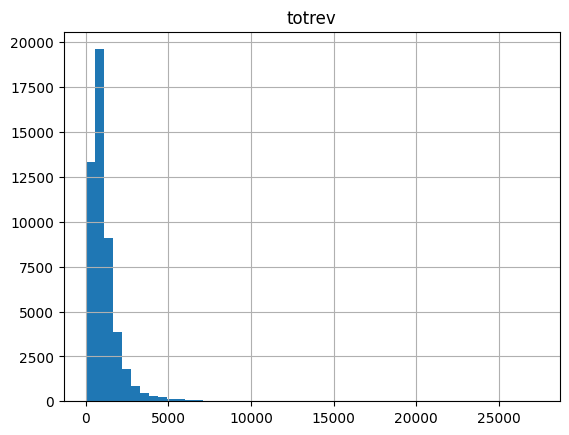

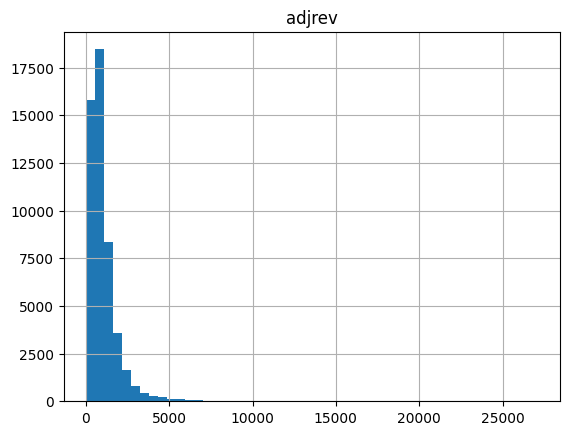

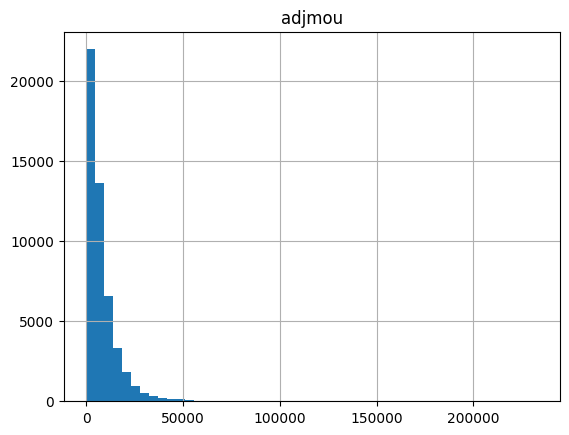

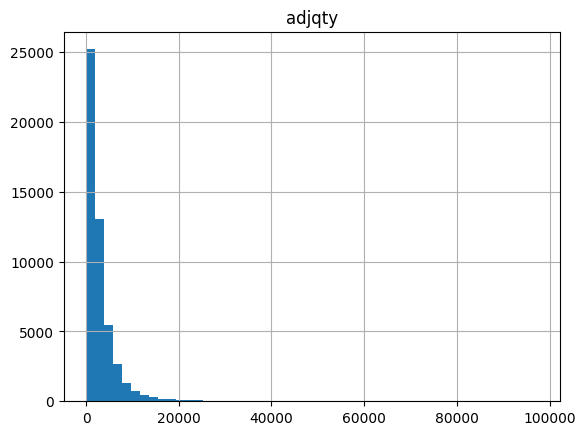

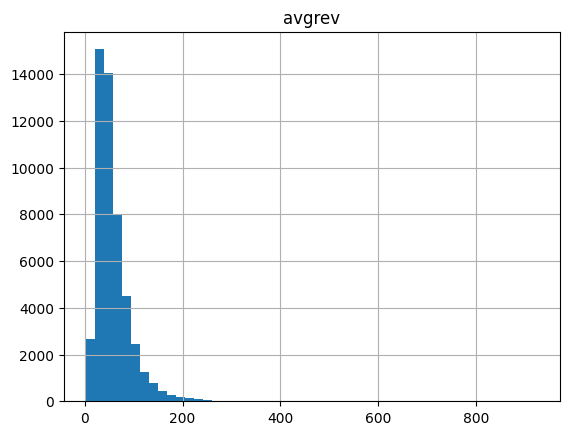

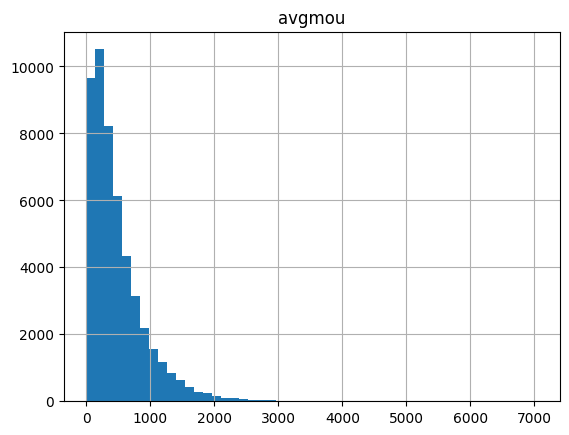

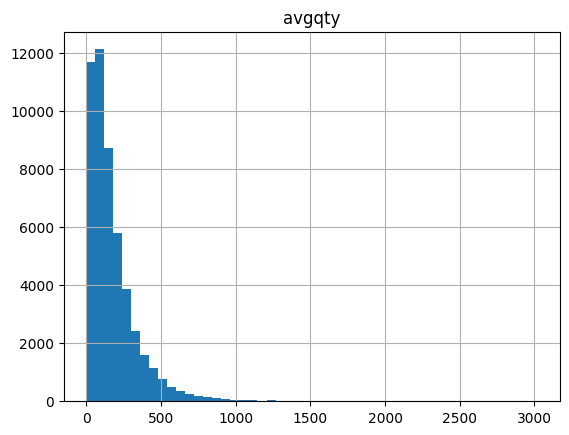

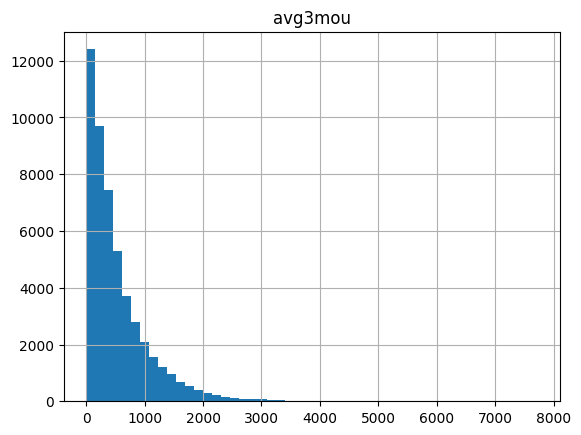

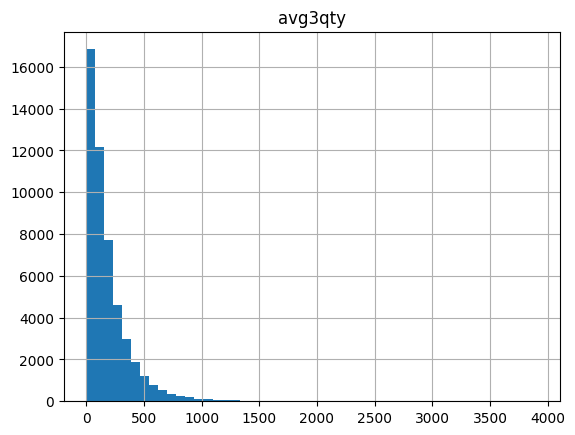

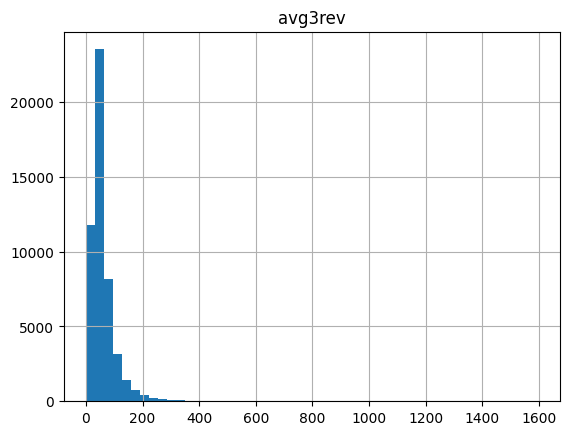

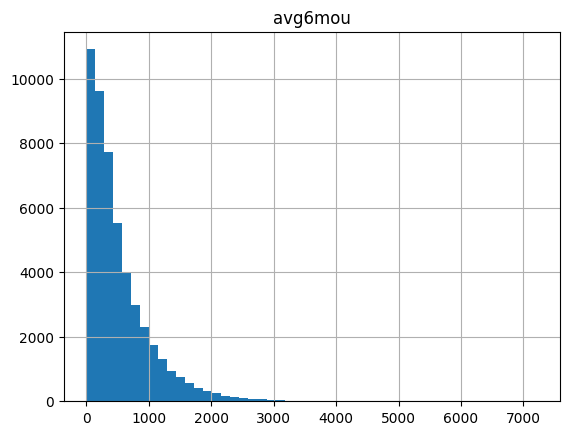

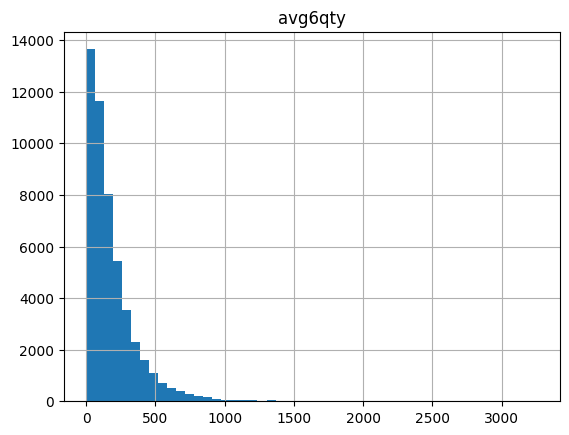

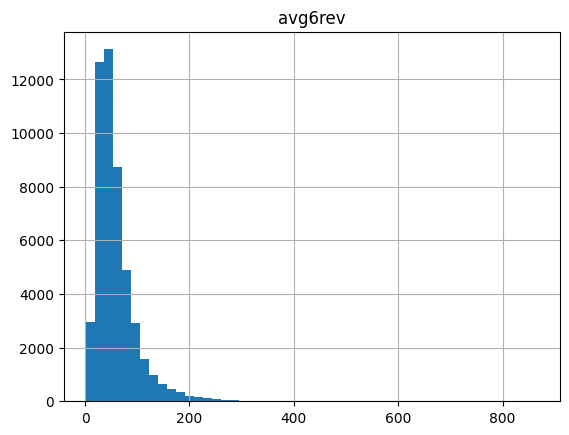

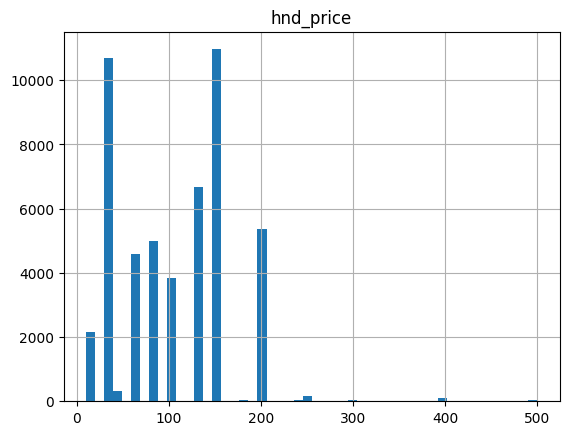

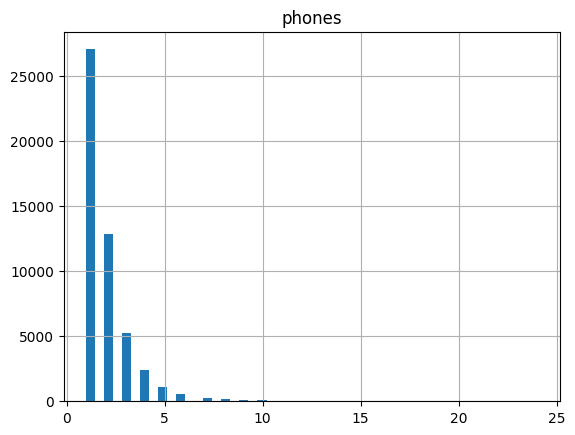

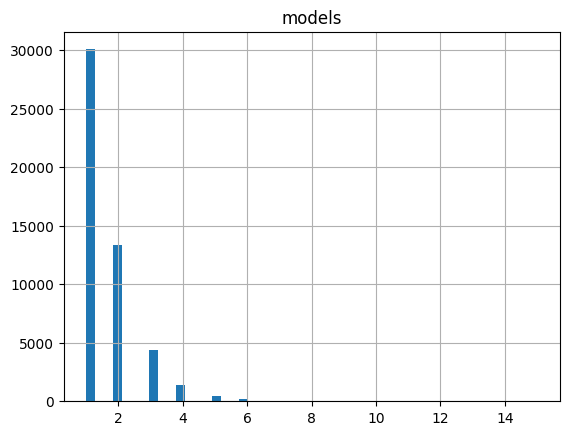

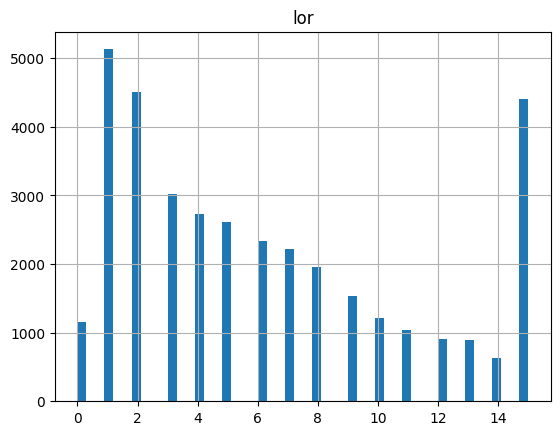

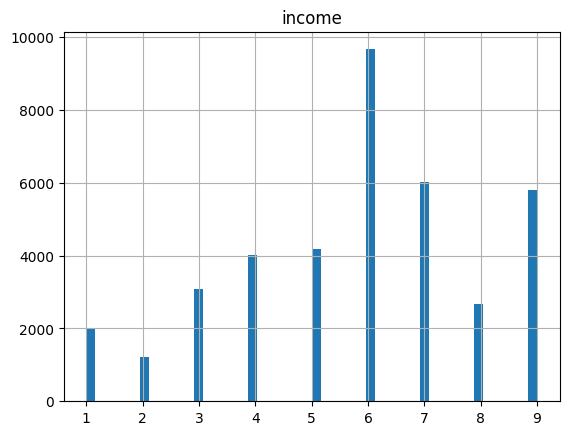

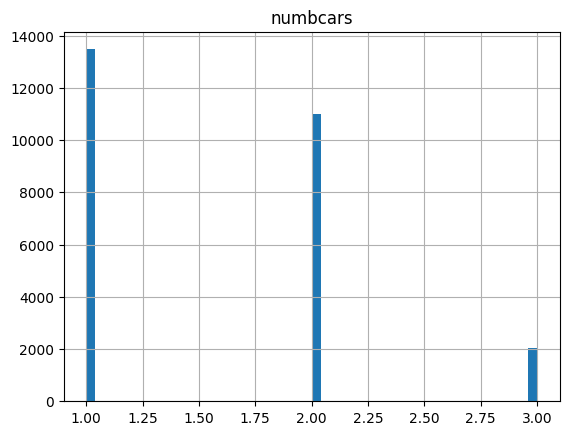

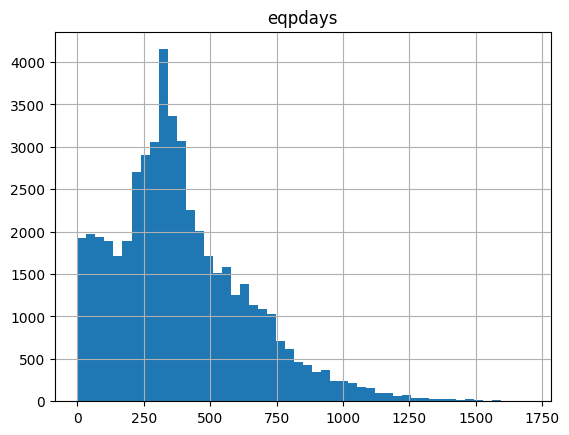

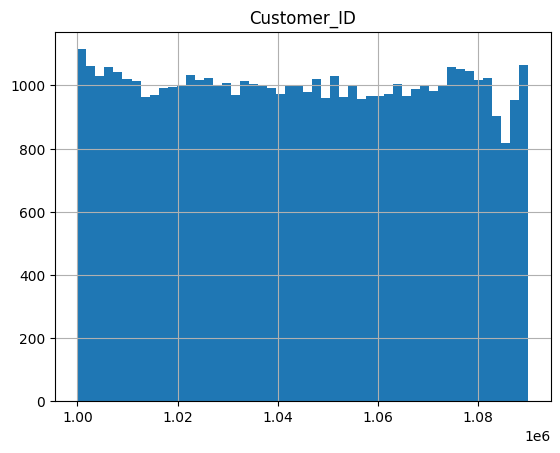

In [1358]:
for col in lista_numericas:
    df.hist(col, bins=50)

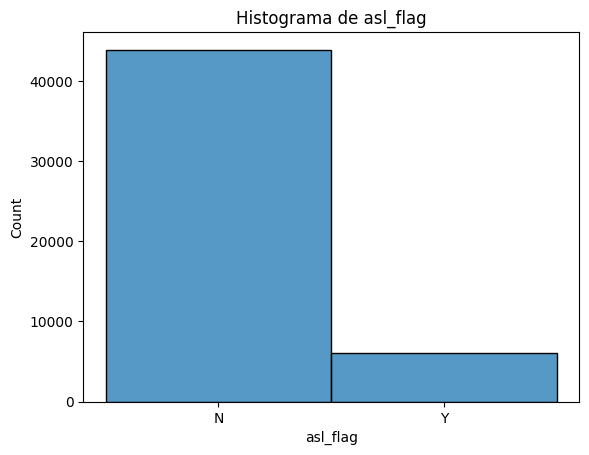

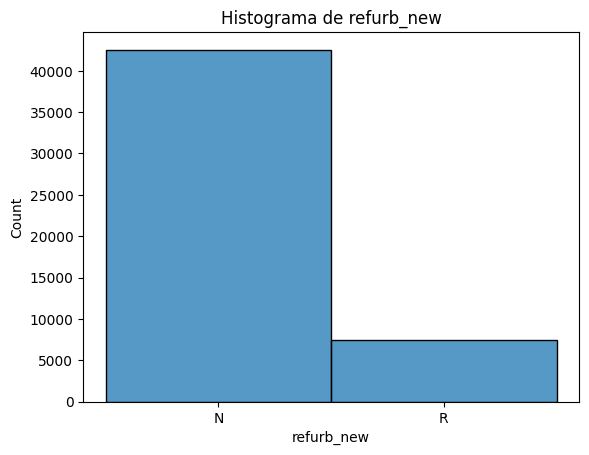

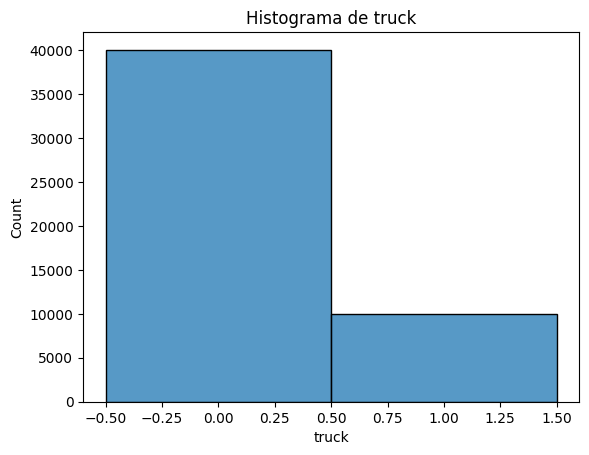

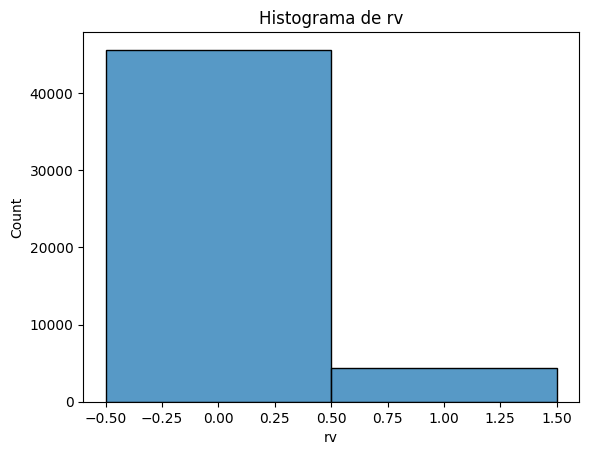

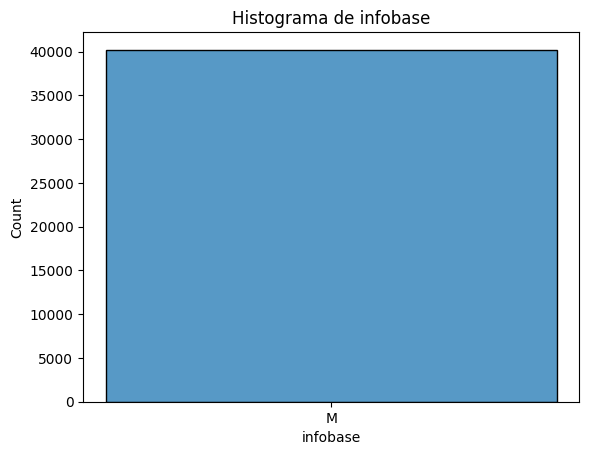

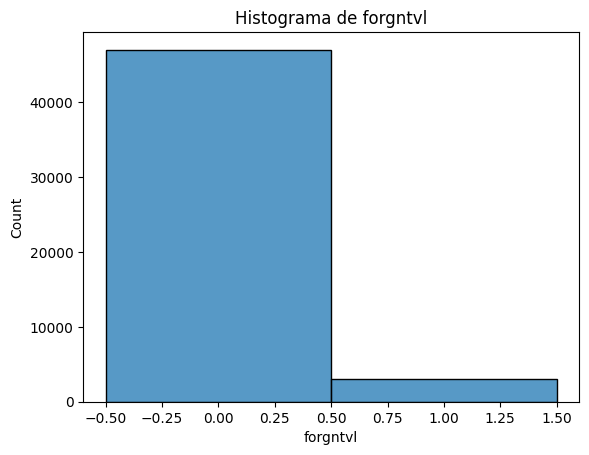

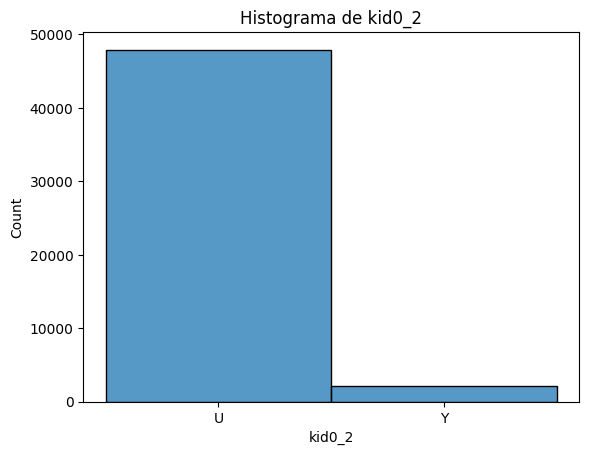

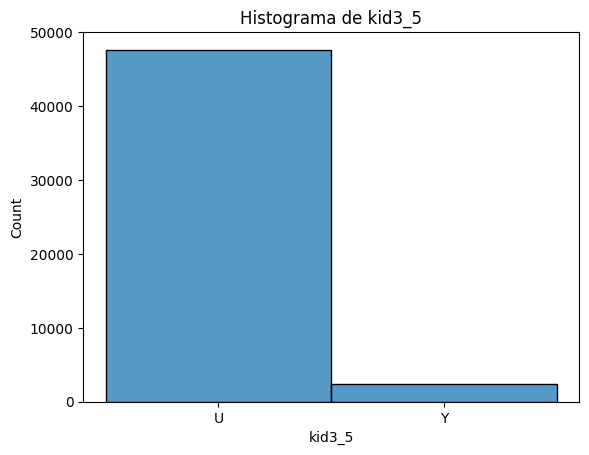

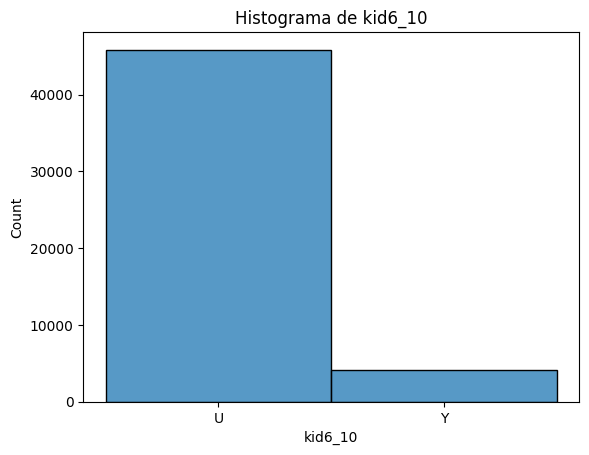

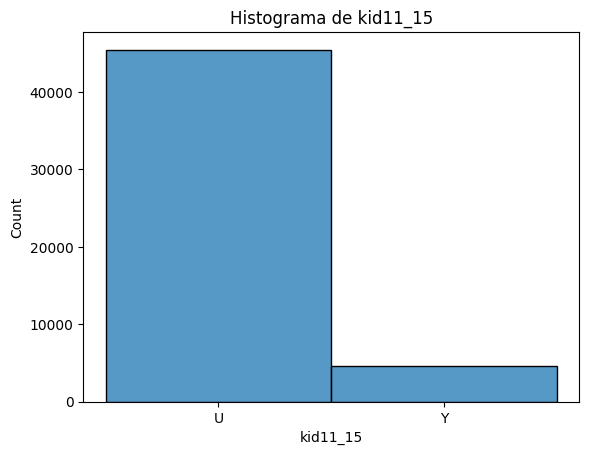

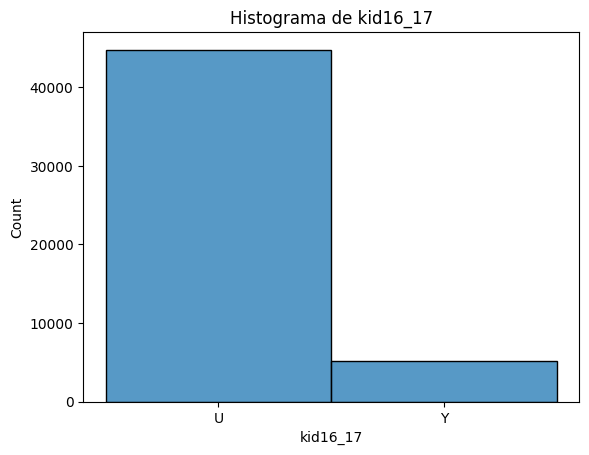

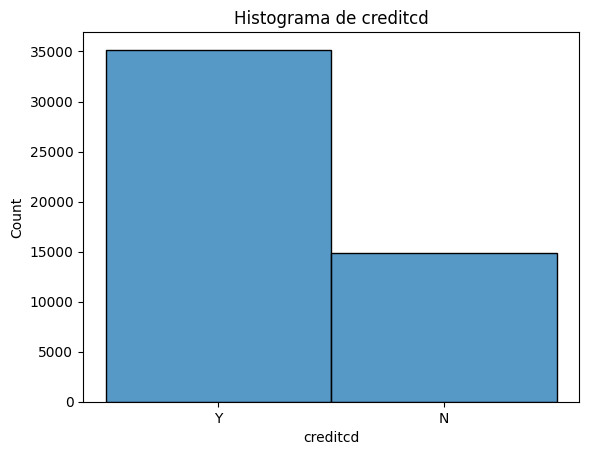

In [1359]:
for col in lista_boolean:
    sns.histplot(data=df, x=col, discrete=True)
    plt.title(f'Histograma de {col}')
    plt.show()

In [1360]:
# borramos infobase
df.drop(columns='infobase', inplace=True)
df_pred.drop(columns='infobase', inplace=True)

In [1361]:
# comprobamos que los Customer_ID no coinciden
df_customer_id = df['Customer_ID'].to_list()
df_pred_customer_id = df_pred['Customer_ID'].to_list()

coincide = [x for x in df_customer_id if x in df_pred_customer_id]
coincide

[]

In [1362]:
# nos guardamos los Customer_ID de df_pred
customer_id_pred = df_pred['Customer_ID']
# borramos Customer_ID
df.drop(columns='Customer_ID', inplace=True)
df_pred.drop(columns='Customer_ID', inplace=True)

In [1363]:
for col in lista_categoricas:
    print(df[col].value_counts(normalize=True, dropna=False))
    print()

crclscod
AA    0.373367
A     0.175204
BA    0.123242
CA    0.083022
EA    0.066321
B     0.042261
DA    0.037101
ZA    0.036821
C     0.016920
A2    0.008140
U     0.005080
E     0.004040
E4    0.003240
D     0.003020
GA    0.002960
G     0.002580
Z     0.002140
JF    0.002060
M     0.001760
C2    0.001380
W     0.001140
I     0.001140
D4    0.001100
Z4    0.000860
U1    0.000640
V1    0.000580
EM    0.000540
EC    0.000420
B2    0.000360
E2    0.000280
O     0.000280
CY    0.000220
J     0.000200
D5    0.000180
CC    0.000180
Y     0.000180
K     0.000160
C5    0.000160
Z5    0.000120
Z1    0.000120
ZY    0.000100
Z2    0.000080
A3    0.000040
D2    0.000040
TP    0.000040
H     0.000040
EF    0.000040
IF    0.000040
P1    0.000020
GY    0.000020
ZF    0.000020
Name: proportion, dtype: float64

prizm_social_one
S      0.327247
U      0.237825
C      0.170163
T      0.151363
NaN    0.065841
R      0.047561
Name: proportion, dtype: float64

area
NEW YORK CITY AREA               0.11538

### Columnas candidatas para ser borradas por escasa varianza: blck_dat, roam, comp_dat, peak_dat, opk_dat, mou_opkd
### Columnas numericas que podrian ser tratadas como categoricas: uniqsubs, actvsubs, phones, models, lor, income, numbcars, 

### Analisis variables-target

In [1364]:
# graficos_por_fila = 4
# variables = list(df.columns)
# variables.remove(target)
# num_variables =len(variables)

# fig, axs = plt.subplots(ncols=graficos_por_fila, nrows=(num_variables + graficos_por_fila - 1) // graficos_por_fila, figsize=(15,60))
# axs = axs.flatten()

# for i, var in enumerate(variables):
#     sns.scatterplot(data=df, x=var, y=target, ax=axs[i], hue=target)
#     axs[i].set_title(f'{var} vs {target}')
#     axs[i].set_xlabel(var)
#     axs[i].set_ylabel(target)

# plt.tight_layout()

# Preprocessing

## Data Cleaning

### Duplicados

In [1365]:
df[df.duplicated()]

Empty DataFrame
Columns: [rev, mou, totmrc, ovrmou, ovrrev, vceovr, roam, change_mou, change_rev, drop_vce, blck_vce, blck_dat, unan_vce, plcd_vce, recv_vce, comp_vce, comp_dat, custcare, ccrndmou, cc_mou, inonemin, threeway, mou_cvce, mou_rvce, owylis_vce, mouowylisv, iwylis_vce, mouiwylisv, peak_vce, peak_dat, mou_peav, opk_vce, opk_dat, mou_opkv, mou_opkd, drop_blk, attempt, complete, callwait, churn, months, uniqsubs, actvsubs, crclscod, asl_flag, totcalls, totmou, totrev, adjrev, adjmou, adjqty, avgrev, avgmou, avgqty, avg3mou, avg3qty, avg3rev, avg6mou, avg6qty, avg6rev, prizm_social_one, area, dualband, refurb_new, hnd_price, phones, models, hnd_webcap, truck, rv, ownrent, lor, marital, income, numbcars, forgntvl, ethnic, kid0_2, kid3_5, kid6_10, kid11_15, kid16_17, creditcd, eqpdays]
Index: []

[0 rows x 84 columns]

## Tratamiento de nulos

In [1366]:
# df_nulos
df_nulls = df.isna().sum().reset_index(name='nulls')
df_nulls[df_nulls['nulls']>0].sort_values(by='nulls')

index  nulls
61              area    720
60  prizm_social_one   3292
67        hnd_webcap   4971
73            income  11312
71               lor  13713
70           ownrent  15446
74          numbcars  23480

In [1367]:
# df_pred nulos
df_pred_nulls = df_pred.isna().sum().reset_index(name='nulls')
df_pred_nulls[df_pred_nulls['nulls']>0].sort_values(by='nulls')

index  nulls
6               roam     25
61          dualband     25
59  prizm_social_one     88
66        hnd_webcap    155
72            income    305
70               lor    390
69           ownrent    427
73          numbcars    676

### area

In [1368]:
df['area'].value_counts(dropna=False, normalize=True)*100

area
NEW YORK CITY AREA               11.538231
DC/MARYLAND/VIRGINIA AREA         6.676134
MIDWEST AREA                      6.578132
ATLANTIC SOUTH AREA               6.058121
CALIFORNIA NORTH AREA             5.910118
DALLAS AREA                       5.688114
NEW ENGLAND AREA                  5.340107
SOUTHWEST AREA                    5.266105
CHICAGO AREA                      5.156103
LOS ANGELES AREA                  4.860097
GREAT LAKES AREA                  4.842097
OHIO AREA                         4.840097
HOUSTON AREA                      4.290086
CENTRAL/SOUTH TEXAS AREA          4.278086
NORTH FLORIDA AREA                4.250085
NORTHWEST/ROCKY MOUNTAIN AREA     4.226085
SOUTH FLORIDA AREA                3.362067
TENNESSEE AREA                    2.886058
PHILADELPHIA AREA                 2.514050
NaN                               1.440029
Name: proportion, dtype: float64

##### No tenemos manera de saber el area. Imputamos 'Unknown'

In [1369]:
# Imputamos 'Unknown'
df['area'].fillna('Unknown', inplace=True)

df['area'].value_counts(dropna=False, normalize=True)*100

area
NEW YORK CITY AREA               11.538231
DC/MARYLAND/VIRGINIA AREA         6.676134
MIDWEST AREA                      6.578132
ATLANTIC SOUTH AREA               6.058121
CALIFORNIA NORTH AREA             5.910118
DALLAS AREA                       5.688114
NEW ENGLAND AREA                  5.340107
SOUTHWEST AREA                    5.266105
CHICAGO AREA                      5.156103
LOS ANGELES AREA                  4.860097
GREAT LAKES AREA                  4.842097
OHIO AREA                         4.840097
HOUSTON AREA                      4.290086
CENTRAL/SOUTH TEXAS AREA          4.278086
NORTH FLORIDA AREA                4.250085
NORTHWEST/ROCKY MOUNTAIN AREA     4.226085
SOUTH FLORIDA AREA                3.362067
TENNESSEE AREA                    2.886058
PHILADELPHIA AREA                 2.514050
Unknown                           1.440029
Name: proportion, dtype: float64

### prizm_social_one: "Social group letter only"
##### probablemente signifiquen 'Suburban', 'Urban', 'Country', 'Town', 'Rural'. No podemos clasificarlos ordinalmente

In [1370]:
df['prizm_social_one'].value_counts(dropna=False, normalize=True)*100

prizm_social_one
S      32.724654
U      23.782476
C      17.016340
T      15.136303
NaN     6.584132
R       4.756095
Name: proportion, dtype: float64

In [1371]:
# Imputamos 'Unknown'
df['prizm_social_one'].fillna('Unknown', inplace=True)
df_pred['prizm_social_one'].fillna('Unknown', inplace=True)

df['prizm_social_one'].value_counts(dropna=False, normalize=True)*100

prizm_social_one
S          32.724654
U          23.782476
C          17.016340
T          15.136303
Unknown     6.584132
R           4.756095
Name: proportion, dtype: float64

### hnd_webcap: "Handset web capability"
##### Capacidad del dispositivo para acceder a la web. Podemos clasificar los nulos como 'Unknown'

In [1372]:
df['hnd_webcap'].value_counts(dropna=False, normalize=True)*100

hnd_webcap
WCMB    77.101542
WC      12.956259
NaN      9.942199
Name: proportion, dtype: float64

In [1373]:
# Imputamos 'Unknown'
df['hnd_webcap'].fillna('Unknown', inplace=True)
df_pred['hnd_webcap'].fillna('Unknown', inplace=True)

df['hnd_webcap'].value_counts(dropna=False, normalize=True)*100

hnd_webcap
WCMB       77.101542
WC         12.956259
Unknown     9.942199
Name: proportion, dtype: float64

### income: "Estimated income"

In [1374]:
df['income'].value_counts(dropna=False, normalize=True)*100

income
NaN    22.624452
6.0    19.332387
7.0    12.068241
9.0    11.616232
5.0     8.350167
4.0     8.024160
3.0     6.144123
8.0     5.368107
1.0     4.050081
2.0     2.422048
Name: proportion, dtype: float64

##### Los numeros de income (1-9) representan grupos de ingresos. Vamos a ver cuanto gasta al mes grupo uno de media:

In [1375]:
df.groupby('income', dropna=False)['rev'].mean().sort_index()


income
1.0    63.069647
2.0    61.346250
3.0    60.015719
4.0    57.659438
5.0    58.232545
6.0    55.903128
7.0    56.490268
8.0    58.322053
9.0    56.496586
NaN    66.218505
Name: rev, dtype: float64

##### Siguen un orden lineal de gasto. Asumiremos que los NaN tienen income = 0.0

In [1376]:
# Imputamos 0.0
df['income'].fillna(0.0, inplace=True)
df_pred['income'].fillna(0.0, inplace=True)

df['income'].value_counts(dropna=False, normalize=True)*100

income
0.0    22.624452
6.0    19.332387
7.0    12.068241
9.0    11.616232
5.0     8.350167
4.0     8.024160
3.0     6.144123
8.0     5.368107
1.0     4.050081
2.0     2.422048
Name: proportion, dtype: float64

### lor: "Length of residence"
##### Representa el tiempo que lleva el cliente viviendo en su domicilio actual

In [1377]:
df['lor'].value_counts(dropna=False, normalize=True)*100

lor
NaN     27.426549
1.0     10.262205
2.0      9.030181
15.0     8.810176
3.0      6.048121
4.0      5.462109
5.0      5.212104
6.0      4.662093
7.0      4.444089
8.0      3.904078
9.0      3.072061
10.0     2.438049
0.0      2.298046
11.0     2.070041
12.0     1.812036
13.0     1.798036
14.0     1.250025
Name: proportion, dtype: float64

##### No tenemos ni idea de que puede ser NaN, asi que imputaremos Unknown
##### Para evitar generar demasiadas columnas con el OneHotEncoder, dividiremos los valores en categorias

<Axes: xlabel='lor', ylabel='churn'>

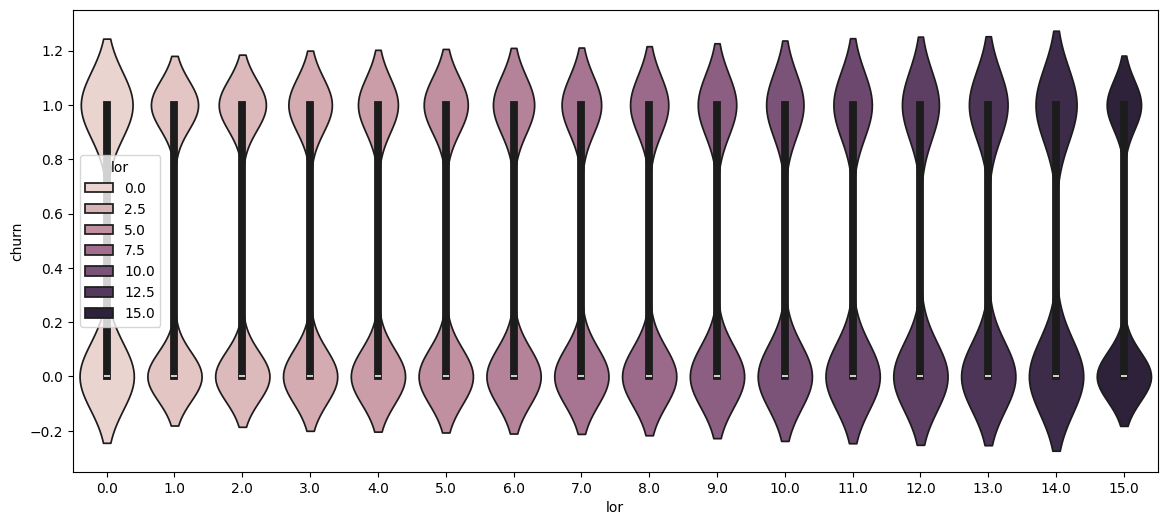

In [1378]:
plt.figure(figsize=(14,6))
sns.violinplot(data=df, x='lor', y=target, hue='lor')

In [1379]:
# 0-3, 4-6, 7-9, 10-12, 13-15, Unknown
def lor_cat(year):
    if pd.isna(year):
        return 'Unknown'
    if year >= 0.0 and year <=3.0:
        return '0-3'
    if year >= 4.0 and year <=6.0:
        return '4-6'
    if year >= 7.0 and year <=9.0:
        return '7-9'
    if year >= 10.0 and year <=12.0:
        return '10-12'
    if year >= 13.0:
        return '13-15'
    return 'Other'

In [1380]:
# nos guardamos el valor original de df['lor']
lor_original = df['lor']

# aplicamos la funcion a df y df_pred
df['lor'] = df['lor'].apply(lambda x: lor_cat(x))
df_pred['lor'] = df_pred['lor'].apply(lambda x: lor_cat(x))

# comprobamos que ha funcionado como esperabamos
df[['lor']].merge(lor_original, left_index=True, right_index=True)

lor_x  lor_y
0      13-15   15.0
1        4-6    5.0
2        0-3    1.0
3        7-9    8.0
4        0-3    0.0
...      ...    ...
49995    0-3    1.0
49996    0-3    2.0
49997    0-3    1.0
49998    0-3    3.0
49999    0-3    2.0

[49999 rows x 2 columns]

In [1381]:
df['lor'].value_counts(normalize=True)*100

lor
0-3        27.638553
Unknown    27.426549
4-6        15.336307
13-15      11.858237
7-9        11.420228
10-12       6.320126
Name: proportion, dtype: float64

<Axes: xlabel='lor', ylabel='churn'>

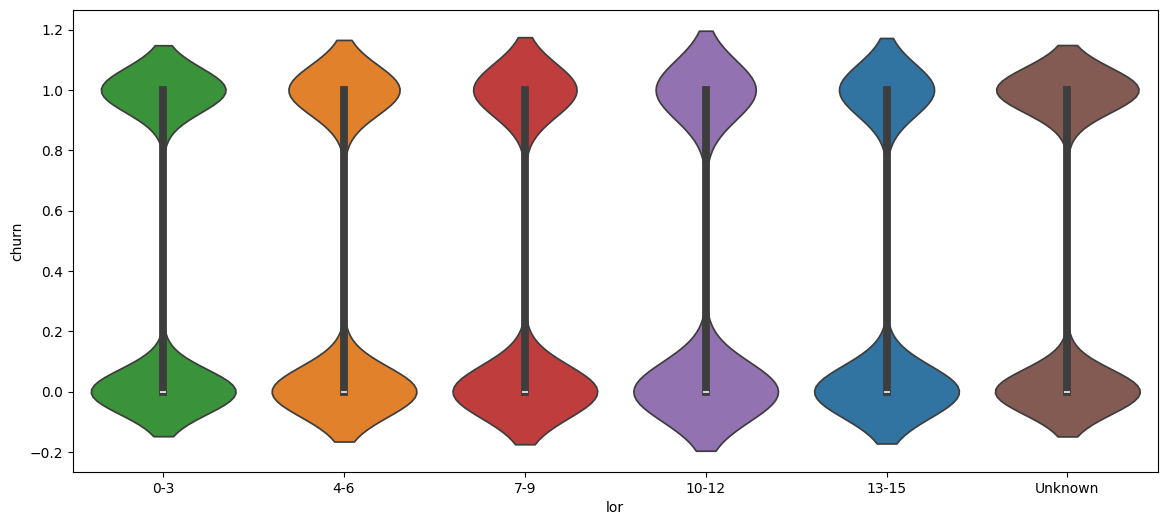

In [1382]:
order = ['0-3', '4-6', '7-9', '10-12', '13-15', 'Unknown']
plt.figure(figsize=(14,6))
sns.violinplot(data=df, x='lor', y=target, hue='lor', order=order)

### ownrent: "Home owner/renter status"
##### Representa si el cliente tiene una casa en propiedad o vive de alquiler

In [1383]:
df['ownrent'].value_counts(dropna=False, normalize=True)*100

ownrent
O      67.119342
NaN    30.892618
R       1.988040
Name: proportion, dtype: float64

In [1384]:
# Imputamos 'Unknown'
df['ownrent'].fillna('Unknown', inplace=True)
df_pred['ownrent'].fillna('Unknown', inplace=True)

df['ownrent'].value_counts(dropna=False, normalize=True)*100

ownrent
O          67.119342
Unknown    30.892618
R           1.988040
Name: proportion, dtype: float64

### numbcars: "Known number of vehicles"

In [1385]:
df['numbcars'].value_counts(dropna=False, normalize=True)*100

numbcars
NaN    46.960939
1.0    26.950539
2.0    22.012440
3.0     4.076082
Name: proportion, dtype: float64

##### Asumimos que los NaN no tienen coche

In [1386]:
# Imputamos 0.0
df['numbcars'].fillna(0.0, inplace=True)
df_pred['numbcars'].fillna(0.0, inplace=True)

df['numbcars'].value_counts(dropna=False, normalize=True)*100

numbcars
0.0    46.960939
1.0    26.950539
2.0    22.012440
3.0     4.076082
Name: proportion, dtype: float64

##### df_nulls restantes

In [1387]:
df_nulls = df.isna().sum().reset_index(name='nulls')
df_nulls[df_nulls['nulls']>0].sort_values(by='nulls')

Empty DataFrame
Columns: [index, nulls]
Index: []

##### df_pred_nulls restantes


In [1388]:
df_pred_nulls = df_pred.isna().sum().reset_index(name='nulls')
df_pred_nulls[df_pred_nulls['nulls']>0].sort_values(by='nulls')

index  nulls
6       roam     25
61  dualband     25

### roam: "Mean number of roaming calls"

In [1389]:
df_pred['roam'].value_counts(dropna=False, normalize=True)*100

roam
0.0000     65.400000
0.0975      3.466667
NaN         1.666667
0.1600      1.466667
0.1950      1.266667
             ...    
0.6900      0.066667
2.7700      0.066667
0.7150      0.066667
10.6700     0.066667
3.8825      0.066667
Name: proportion, Length: 309, dtype: float64

In [1390]:
# Imputamos la mediana
df_pred['roam'].fillna(df_pred['roam'].median(), inplace=True)

df_pred['roam'].value_counts(dropna=False, normalize=True)*100

roam
0.0000     67.066667
0.0975      3.466667
0.1600      1.466667
0.1950      1.266667
0.3200      0.733333
             ...    
0.6900      0.066667
2.7700      0.066667
0.7150      0.066667
10.6700     0.066667
3.8825      0.066667
Name: proportion, Length: 308, dtype: float64

### dualband

In [1391]:
df_pred['dualband'].value_counts(dropna=False, normalize=True)*100

dualband
Y      73.400000
N      21.933333
T       3.000000
NaN     1.666667
Name: proportion, dtype: float64

In [1392]:
# Imputamos la moda
df_pred['dualband'].fillna(df_pred['dualband'].mode()[0], inplace=True)

df_pred['dualband'].value_counts(dropna=False, normalize=True)*100

dualband
Y    75.066667
N    21.933333
T     3.000000
Name: proportion, dtype: float64

In [1393]:
df_pred_nulls = df_pred.isna().sum().reset_index(name='nulls')
df_pred_nulls[df_pred_nulls['nulls']>0].sort_values(by='nulls')

Empty DataFrame
Columns: [index, nulls]
Index: []

## Tratamiento de variables categóricas

In [1394]:
df.select_dtypes(include='object').columns

Index(['crclscod', 'asl_flag', 'prizm_social_one', 'area', 'dualband',
       'refurb_new', 'hnd_webcap', 'ownrent', 'lor', 'marital', 'ethnic',
       'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd'],
      dtype='object')

### crclscod: "Credit class code"

In [1395]:
df_crclscod = df['crclscod'].value_counts(normalize=True).reset_index()
df_crclscod['cumsum'] = df_crclscod['proportion'].cumsum()
df_crclscod

crclscod  proportion    cumsum
0        AA    0.373367  0.373367
1         A    0.175204  0.548571
2        BA    0.123242  0.671813
3        CA    0.083022  0.754835
4        EA    0.066321  0.821156
5         B    0.042261  0.863417
6        DA    0.037101  0.900518
7        ZA    0.036821  0.937339
8         C    0.016920  0.954259
9        A2    0.008140  0.962399
10        U    0.005080  0.967479
11        E    0.004040  0.971519
12       E4    0.003240  0.974759
13        D    0.003020  0.977780
14       GA    0.002960  0.980740
15        G    0.002580  0.983320
16        Z    0.002140  0.985460
17       JF    0.002060  0.987520
18        M    0.001760  0.989280
19       C2    0.001380  0.990660
20        W    0.001140  0.991800
21        I    0.001140  0.992940
22       D4    0.001100  0.994040
23       Z4    0.000860  0.994900
24       U1    0.000640  0.995540
25       V1    0.000580  0.996120
26       EM    0.000540  0.996660
27       EC    0.000420  0.997080
28       B2    0.000360  0.997440
29       E2    0.000280  0.997720
30        O    0.000280  0.998000
31       CY    0.000220  0.998220
32        J    0.000200  0.998420
33       D5    0.000180  0.998600
34       CC    0.000180  0.998780
35        Y    0.000180  0.998960
36        K    0.000160  0.999120
37       C5    0.000160  0.999280
38       Z5    0.000120  0.999400
39       Z1    0.000120  0.999520
40       ZY    0.000100  0.999620
41       Z2    0.000080  0.999700
42       A3    0.000040  0.999740
43       D2    0.000040  0.999780
44       TP    0.000040  0.999820
45        H    0.000040  0.999860
46       EF    0.000040  0.999900
47       IF    0.000040  0.999940
48       P1    0.000020  0.999960
49       GY    0.000020  0.999980
50       ZF    0.000020  1.000000

In [1396]:
top_90_crclscod = df_crclscod[df_crclscod['cumsum']<0.9]
top_90_crclscod = top_90_crclscod['crclscod'].to_list()

In [1397]:
df['crclscod'] = df['crclscod'].apply(lambda x: x if x in top_90_crclscod else 'other')
df_pred['crclscod'] = df_pred['crclscod'].apply(lambda x: x if x in top_90_crclscod else 'other')

df['crclscod'].value_counts(normalize=True, ascending=False)

crclscod
AA       0.373367
A        0.175204
other    0.136583
BA       0.123242
CA       0.083022
EA       0.066321
B        0.042261
Name: proportion, dtype: float64

### area

In [1398]:
df['area'].value_counts(normalize=True)*100

area
NEW YORK CITY AREA               11.538231
DC/MARYLAND/VIRGINIA AREA         6.676134
MIDWEST AREA                      6.578132
ATLANTIC SOUTH AREA               6.058121
CALIFORNIA NORTH AREA             5.910118
DALLAS AREA                       5.688114
NEW ENGLAND AREA                  5.340107
SOUTHWEST AREA                    5.266105
CHICAGO AREA                      5.156103
LOS ANGELES AREA                  4.860097
GREAT LAKES AREA                  4.842097
OHIO AREA                         4.840097
HOUSTON AREA                      4.290086
CENTRAL/SOUTH TEXAS AREA          4.278086
NORTH FLORIDA AREA                4.250085
NORTHWEST/ROCKY MOUNTAIN AREA     4.226085
SOUTH FLORIDA AREA                3.362067
TENNESSEE AREA                    2.886058
PHILADELPHIA AREA                 2.514050
Unknown                           1.440029
Name: proportion, dtype: float64

In [1399]:
# area va a introducir mucho ruido en el modelo (demasiadas columnas). La borramos
df.drop(columns='area', inplace=True)
df_pred.drop(columns='area', inplace=True)

### ethnic

In [1400]:
df['ethnic'].value_counts(normalize=True).cumsum()

ethnic
N    0.343967
H    0.479390
S    0.610392
U    0.720834
G    0.781356
Z    0.831517
O    0.872657
I    0.912298
J    0.942259
F    0.963799
B    0.978060
R    0.988640
D    0.997360
M    0.998760
P    0.999960
X    1.000000
Name: proportion, dtype: float64

In [1401]:
df_pred['ethnic'].value_counts(normalize=True).cumsum()

ethnic
N    0.374000
S    0.498667
H    0.618667
U    0.728667
G    0.791333
Z    0.841333
O    0.884667
I    0.915333
F    0.938000
J    0.960000
R    0.978000
B    0.991333
D    0.998000
M    0.999333
P    1.000000
Name: proportion, dtype: float64

In [1402]:
df_ethnic = df['ethnic'].value_counts(normalize=True).reset_index()
df_ethnic['cumsum'] = df_ethnic['proportion'].cumsum()
df_ethnic

ethnic  proportion    cumsum
0       N    0.343967  0.343967
1       H    0.135423  0.479390
2       S    0.131003  0.610392
3       U    0.110442  0.720834
4       G    0.060521  0.781356
5       Z    0.050161  0.831517
6       O    0.041141  0.872657
7       I    0.039641  0.912298
8       J    0.029961  0.942259
9       F    0.021540  0.963799
10      B    0.014260  0.978060
11      R    0.010580  0.988640
12      D    0.008720  0.997360
13      M    0.001400  0.998760
14      P    0.001200  0.999960
15      X    0.000040  1.000000

In [1403]:
ethnic_top90 = df_ethnic[df_ethnic['cumsum']<0.9]
ethnic_top90 = ethnic_top90['ethnic'].to_list()
ethnic_top90

['N', 'H', 'S', 'U', 'G', 'Z', 'O']

In [1404]:
df['ethnic'] = df['ethnic'].apply(lambda x: x if x in ethnic_top90 else 'other')
df_pred['ethnic'] = df_pred['ethnic'].apply(lambda x: x if x in ethnic_top90 else 'other')

df['ethnic'].value_counts(normalize=True)

ethnic
N        0.343967
H        0.135423
S        0.131003
other    0.127343
U        0.110442
G        0.060521
Z        0.050161
O        0.041141
Name: proportion, dtype: float64

In [1405]:
df_pred['ethnic'].value_counts(normalize=True)

ethnic
N        0.374000
S        0.124667
H        0.120000
other    0.115333
U        0.110000
G        0.062667
Z        0.050000
O        0.043333
Name: proportion, dtype: float64

### variables categoricas booleanas

In [1406]:
# asl_flag
df['asl_flag'] = df['asl_flag'].apply(lambda x: 0 if x=='N' else 1)
df_pred['asl_flag'] = df_pred['asl_flag'].apply(lambda x: 0 if x=='N' else 1)

df['asl_flag'].value_counts(normalize=True)

asl_flag
0    0.877798
1    0.122202
Name: proportion, dtype: float64

In [1407]:
# refurb_new
df['refurb_new'] = df['refurb_new'].apply(lambda x: 0 if x=='N' else 1)
df_pred['refurb_new'] = df_pred['refurb_new'].apply(lambda x: 0 if x=='N' else 1)

df['refurb_new'].value_counts()

refurb_new
0    42560
1     7439
Name: count, dtype: int64

In [1408]:
# kid0_2
df['kid0_2'] = df['kid0_2'].apply(lambda x: 0 if x=='U' else 1)
df_pred['kid0_2'] = df_pred['kid0_2'].apply(lambda x: 0 if x=='U' else 1)

df['kid0_2'].value_counts()

kid0_2
0    47941
1     2058
Name: count, dtype: int64

In [1409]:
# kid3_5
df['kid3_5'] = df['kid3_5'].apply(lambda x: 0 if x=='U' else 1)
df_pred['kid3_5'] = df_pred['kid3_5'].apply(lambda x: 0 if x=='U' else 1)

df['kid3_5'].value_counts()

kid3_5
0    47647
1     2352
Name: count, dtype: int64

In [1410]:
# kid6_10
df['kid6_10'] = df['kid6_10'].apply(lambda x: 0 if x=='U' else 1)
df_pred['kid6_10'] = df_pred['kid6_10'].apply(lambda x: 0 if x=='U' else 1)

df['kid6_10'].value_counts()

kid6_10
0    45861
1     4138
Name: count, dtype: int64

In [1411]:
# kid11_15
df['kid11_15'] = df['kid11_15'].apply(lambda x: 0 if x=='U' else 1)
df_pred['kid11_15'] = df_pred['kid11_15'].apply(lambda x: 0 if x=='U' else 1)

df['kid11_15'].value_counts()

kid11_15
0    45459
1     4540
Name: count, dtype: int64

In [1412]:
# kid16_17
df['kid16_17'] = df['kid16_17'].apply(lambda x: 0 if x=='U' else 1)
df_pred['kid16_17'] = df_pred['kid16_17'].apply(lambda x: 0 if x=='U' else 1)

df['kid16_17'].value_counts()

kid16_17
0    44802
1     5197
Name: count, dtype: int64

In [1413]:
# creditcd
df['creditcd'] = df['creditcd'].apply(lambda x: 0 if x=='N' else 1)
df_pred['creditcd'] = df_pred['creditcd'].apply(lambda x: 0 if x=='N' else 1)

df['creditcd'].value_counts()

creditcd
1    35176
0    14823
Name: count, dtype: int64

### one hot encoding

In [1414]:
cols_categoricas = df.select_dtypes(include='object').columns.to_list()
cols_categoricas

['crclscod',
 'prizm_social_one',
 'dualband',
 'hnd_webcap',
 'ownrent',
 'lor',
 'marital',
 'ethnic']

In [1415]:
encoder = OneHotEncoder(sparse_output=False)

data_encoded = encoder.fit_transform(df[cols_categoricas])
df_encoded = pd.DataFrame(data_encoded, columns=encoder.get_feature_names_out())
df.drop(columns=cols_categoricas, inplace=True)
df = df.merge(df_encoded, left_index=True, right_index=True)
df

rev      mou  totmrc  ovrmou   ovrrev  vceovr     roam  \
0       23.9975   219.25   22.50    0.00   0.0000     0.0   0.0000   
1       55.2300   570.50   71.98    0.00   0.0000     0.0   0.0000   
2       82.2750  1312.25   75.00    0.00   0.0000     0.0   0.0000   
3       17.1450     0.00   16.99    0.00   0.0000     0.0   0.0000   
4       38.0525   682.50   52.49    0.00   0.0000     0.0   0.0000   
...         ...      ...     ...     ...      ...     ...      ...   
49994   58.9850   391.50   49.99    0.00   0.0000     0.0   0.0000   
49995   29.2650    61.00   29.99   17.25   6.9000     6.9   0.6875   
49996   80.9950   882.00   50.11   49.50  19.7325    17.1  10.4100   
49997   21.9475   140.00   10.00   29.25  11.7000    11.7   0.0000   
49998  125.2700   936.25   79.99  131.75  52.7000    52.7   2.5800   

       change_mou  change_rev   drop_vce  ...  marital_S  marital_U  ethnic_G  \
0         -157.25    -18.9975   0.666667  ...        1.0        0.0       0.0   
1           38.50      0.0000   9.666667  ...        1.0        0.0       0.0   
2          156.75      8.1450  52.000000  ...        1.0        0.0       0.0   
3            0.00     -0.1550   0.000000  ...        0.0        0.0       0.0   
4          147.50     -3.0625   9.000000  ...        0.0        0.0       0.0   
...           ...         ...        ...  ...        ...        ...       ...   
49994      -28.50     -8.9950  24.666667  ...        0.0        0.0       0.0   
49995      -37.00     -9.2750   2.000000  ...        1.0        0.0       0.0   
49996       75.00    -26.7350  12.000000  ...        0.0        0.0       0.0   
49997      123.00     -4.9575   1.000000  ...        0.0        0.0       0.0   
49998      109.75    -22.5000  11.666667  ...        0.0        0.0       0.0   

       ethnic_H  ethnic_N  ethnic_O  ethnic_S  ethnic_U  ethnic_Z  \
0           0.0       1.0       0.0       0.0       0.0       0.0   
1           0.0       0.0       0.0       0.0       0.0       0.0   
2           0.0       0.0       0.0       0.0       1.0       0.0   
3           0.0       1.0       0.0       0.0       0.0       0.0   
4           0.0       0.0       0.0       1.0       0.0       0.0   
...         ...       ...       ...       ...       ...       ...   
49994       0.0       0.0       0.0       1.0       0.0       0.0   
49995       0.0       1.0       0.0       0.0       0.0       0.0   
49996       0.0       0.0       0.0       1.0       0.0       0.0   
49997       0.0       0.0       0.0       0.0       1.0       0.0   
49998       0.0       0.0       0.0       0.0       1.0       0.0   

       ethnic_other  
0               0.0  
1               1.0  
2               0.0  
3               0.0  
4               0.0  
...             ...  
49994           0.0  
49995           0.0  
49996           0.0  
49997           0.0  
49998           0.0  

[49998 rows x 116 columns]

In [1416]:
# aplicamos las transformaciones al df_pred
data_pred_encoded = encoder.transform(df_pred[cols_categoricas])
df_pred_encoded = pd.DataFrame(data_pred_encoded, columns=encoder.get_feature_names_out())
df_pred.drop(columns=cols_categoricas, inplace=True)
df_pred = df_pred.merge(df_pred_encoded, left_index=True, right_index=True)
df_pred


rev      mou    totmrc  ovrmou   ovrrev   vceovr    roam  \
0      31.4475    56.00   30.0000    8.75   1.4475   1.4475  0.0000   
1      76.7375  1007.75   59.9900   65.25  19.5750  19.5750  6.6775   
2     159.0400  2542.50   75.0000  458.25  45.8250  45.8250  9.5600   
3      67.2750   602.50   50.0000   73.25   7.3250   7.3250  4.8000   
4      80.2825  1245.25   68.2950   73.00  18.2500  18.2500  0.0000   
...        ...      ...       ...     ...      ...      ...     ...   
1495   58.3250   507.00   44.9900   55.00  22.0000  22.0000  0.0975   
1496   65.3575   320.00   79.9900    0.00   0.0000   0.0000  3.8825   
1497   76.8425   561.25   80.7425    0.00   0.2000   0.0000  0.0000   
1498   78.6650   984.50   69.9900   55.50  22.2000  22.2000  0.0000   
1499  103.9900  1274.50  119.9900    0.00   0.0000   0.0000  0.0000   

      change_mou  change_rev   drop_vce  ...  marital_S  marital_U  ethnic_G  \
0         -34.00     -1.4475   1.000000  ...        0.0        0.0       1.0   
1         -51.75      5.3625   2.000000  ...        0.0        0.0       0.0   
2        -225.50    -19.3600  34.333333  ...        0.0        0.0       0.0   
3        -155.50    -12.8250  21.666667  ...        1.0        0.0       0.0   
4        -160.25    -62.0725   0.000000  ...        0.0        0.0       0.0   
...          ...         ...        ...  ...        ...        ...       ...   
1495      172.00     48.2550   8.333333  ...        0.0        0.0       0.0   
1496      -38.00      0.5925   5.666667  ...        0.0        0.0       0.0   
1497      -35.25    111.1375  10.000000  ...        0.0        1.0       0.0   
1498     -120.50      8.4850  18.000000  ...        0.0        1.0       0.0   
1499     -531.50      0.0000  59.000000  ...        1.0        0.0       0.0   

      ethnic_H  ethnic_N  ethnic_O  ethnic_S  ethnic_U  ethnic_Z  ethnic_other  
0          0.0       0.0       0.0       0.0       0.0       0.0           0.0  
1          0.0       0.0       0.0       0.0       0.0       0.0           1.0  
2          0.0       1.0       0.0       0.0       0.0       0.0           0.0  
3          0.0       1.0       0.0       0.0       0.0       0.0           0.0  
4          0.0       0.0       0.0       1.0       0.0       0.0           0.0  
...        ...       ...       ...       ...       ...       ...           ...  
1495       0.0       0.0       0.0       0.0       0.0       0.0           1.0  
1496       0.0       0.0       0.0       0.0       0.0       0.0           1.0  
1497       0.0       0.0       0.0       0.0       0.0       1.0           0.0  
1498       0.0       0.0       0.0       0.0       0.0       0.0           1.0  
1499       0.0       1.0       0.0       0.0       0.0       0.0           0.0  

[1500 rows x 115 columns]

## Alta correlación

In [1417]:
df_corr = df.corr(numeric_only=True)
df_corr.style.background_gradient(cmap='coolwarm')

In [1418]:
# nos quedamos con el triangulo superior
df_triangulo = pd.DataFrame(np.triu(df_corr, k=1), columns=df.columns)
df_triangulo.index=df.columns
df_triangulo.head()

rev       mou    totmrc    ovrmou    ovrrev    vceovr      roam  \
rev     0.0  0.721062  0.630059  0.803991  0.806676  0.802072  0.303640   
mou     0.0  0.000000  0.588356  0.582585  0.542442  0.541397  0.127170   
totmrc  0.0  0.000000  0.000000  0.214790  0.173361  0.171810  0.084773   
ovrmou  0.0  0.000000  0.000000  0.000000  0.952835  0.949790  0.074981   
ovrrev  0.0  0.000000  0.000000  0.000000  0.000000  0.994986  0.068981   

        change_mou  change_rev  drop_vce  ...  marital_S  marital_U  ethnic_G  \
rev      -0.042117   -0.059597  0.444040  ...   0.006574   0.034004 -0.003074   
mou      -0.044062   -0.053528  0.600024  ...   0.011588   0.053831 -0.016125   
totmrc   -0.019539   -0.031562  0.354689  ...   0.005660   0.039473  0.000605   
ovrmou   -0.033002   -0.045345  0.350571  ...   0.001425   0.022462 -0.002772   
ovrrev   -0.021271   -0.019346  0.333144  ...   0.002789   0.027044 -0.005497   

        ethnic_H  ethnic_N  ethnic_O  ethnic_S  ethnic_U  ethnic_Z  \
rev     0.016530 -0.014926 -0.021169 -0.002678  0.000872  0.020835   
mou     0.039287 -0.026705 -0.003872 -0.012130  0.000935  0.031463   
totmrc  0.013160 -0.009741 -0.019566 -0.003413  0.002687  0.016493   
ovrmou  0.012201 -0.012671 -0.012598 -0.001441  0.001216  0.016105   
ovrrev  0.012882 -0.012064 -0.010531 -0.002923  0.001163  0.017647   

        ethnic_other  
rev         0.007363  
mou         0.002366  
totmrc      0.001726  
ovrmou      0.004790  
ovrrev      0.004486  

[5 rows x 116 columns]

In [1419]:
# correlaciones superiores a 0.9
cols = ['variable1','variable2','correlacion']
df_stack = df_triangulo.stack().reset_index()
df_stack.columns=cols

df_altas_correlaciones = df_stack[df_stack['correlacion']>0.9]
df_altas_correlaciones

variable1 variable2  correlacion
55         rev   avg3rev     0.960642
169        mou   avg3mou     0.985445
172        mou   avg6mou     0.950891
352     ovrmou    ovrrev     0.952835
353     ovrmou    vceovr     0.949790
469     ovrrev    vceovr     0.994986
1523  plcd_vce  comp_vce     0.985533
1544  plcd_vce   attempt     0.998374
1545  plcd_vce  complete     0.983302
1644  recv_vce  inonemin     0.965659
1768  comp_vce  peak_vce     0.912197
1776  comp_vce   attempt     0.984020
1777  comp_vce  complete     0.997713
1885  comp_dat  peak_dat     0.925497
1888  comp_dat   opk_dat     0.942548
2107  ccrndmou    cc_mou     0.988654
3285  peak_vce  complete     0.909054
4213   attempt  complete     0.985599
5149  totcalls    totmou     0.927845
5152  totcalls    adjmou     0.927645
5153  totcalls    adjqty     0.999846
5268    totmou    adjmou     0.999810
5269    totmou    adjqty     0.927781
5383    totrev    adjrev     0.998733
5617    adjmou    adjqty     0.927894
5972    avgmou   avg6mou     0.938090
6086    avgqty   avg3qty     0.902014
6089    avgqty   avg6qty     0.947278
6204   avg3mou   avg6mou     0.963427
6321   avg3qty   avg6qty     0.969326
6438   avg3rev   avg6rev     0.913393

In [1420]:
# correlaciones con el target
corr_con_target = df_corr[target]

df_altas_correlaciones['corr_var1_target'] = df_altas_correlaciones['variable1'].apply(lambda x: corr_con_target[x])
df_altas_correlaciones['corr_var2_target'] = df_altas_correlaciones['variable2'].apply(lambda x: corr_con_target[x])

df_altas_correlaciones

variable1 variable2  correlacion  corr_var1_target  corr_var2_target
55         rev   avg3rev     0.960642         -0.047296         -0.049333
169        mou   avg3mou     0.985445         -0.137966         -0.121909
172        mou   avg6mou     0.950891         -0.137966         -0.113194
352     ovrmou    ovrrev     0.952835          0.033950          0.044990
353     ovrmou    vceovr     0.949790          0.033950          0.046102
469     ovrrev    vceovr     0.994986          0.044990          0.046102
1523  plcd_vce  comp_vce     0.985533         -0.110264         -0.118003
1544  plcd_vce   attempt     0.998374         -0.110264         -0.110703
1545  plcd_vce  complete     0.983302         -0.110264         -0.118440
1644  recv_vce  inonemin     0.965659         -0.091020         -0.073547
1768  comp_vce  peak_vce     0.912197         -0.118003         -0.111211
1776  comp_vce   attempt     0.984020         -0.118003         -0.110703
1777  comp_vce  complete     0.997713         -0.118003         -0.118440
1885  comp_dat  peak_dat     0.925497         -0.020399         -0.019906
1888  comp_dat   opk_dat     0.942548         -0.020399         -0.018322
2107  ccrndmou    cc_mou     0.988654         -0.081188         -0.078032
3285  peak_vce  complete     0.909054         -0.111211         -0.118440
4213   attempt  complete     0.985599         -0.110703         -0.118440
5149  totcalls    totmou     0.927845         -0.072696         -0.084860
5152  totcalls    adjmou     0.927645         -0.072696         -0.085658
5153  totcalls    adjqty     0.999846         -0.072696         -0.073345
5268    totmou    adjmou     0.999810         -0.084860         -0.085658
5269    totmou    adjqty     0.927781         -0.084860         -0.073345
5383    totrev    adjrev     0.998733         -0.059183         -0.059667
5617    adjmou    adjqty     0.927894         -0.085658         -0.073345
5972    avgmou   avg6mou     0.938090         -0.073059         -0.113194
6086    avgqty   avg3qty     0.902014         -0.068032         -0.104604
6089    avgqty   avg6qty     0.947278         -0.068032         -0.096314
6204   avg3mou   avg6mou     0.963427         -0.121909         -0.113194
6321   avg3qty   avg6qty     0.969326         -0.104604         -0.096314
6438   avg3rev   avg6rev     0.913393         -0.049333         -0.060610

In [1421]:
df_altas_correlaciones['var_menos_corr'] = df_altas_correlaciones.apply(lambda df: df['variable1'] if np.abs(df['corr_var1_target']) > np.abs(df['corr_var2_target']) 
                                                                                     else df['variable2'], axis=1)

In [1422]:
df_altas_correlaciones

variable1 variable2  correlacion  corr_var1_target  corr_var2_target  \
55         rev   avg3rev     0.960642         -0.047296         -0.049333   
169        mou   avg3mou     0.985445         -0.137966         -0.121909   
172        mou   avg6mou     0.950891         -0.137966         -0.113194   
352     ovrmou    ovrrev     0.952835          0.033950          0.044990   
353     ovrmou    vceovr     0.949790          0.033950          0.046102   
469     ovrrev    vceovr     0.994986          0.044990          0.046102   
1523  plcd_vce  comp_vce     0.985533         -0.110264         -0.118003   
1544  plcd_vce   attempt     0.998374         -0.110264         -0.110703   
1545  plcd_vce  complete     0.983302         -0.110264         -0.118440   
1644  recv_vce  inonemin     0.965659         -0.091020         -0.073547   
1768  comp_vce  peak_vce     0.912197         -0.118003         -0.111211   
1776  comp_vce   attempt     0.984020         -0.118003         -0.110703   
1777  comp_vce  complete     0.997713         -0.118003         -0.118440   
1885  comp_dat  peak_dat     0.925497         -0.020399         -0.019906   
1888  comp_dat   opk_dat     0.942548         -0.020399         -0.018322   
2107  ccrndmou    cc_mou     0.988654         -0.081188         -0.078032   
3285  peak_vce  complete     0.909054         -0.111211         -0.118440   
4213   attempt  complete     0.985599         -0.110703         -0.118440   
5149  totcalls    totmou     0.927845         -0.072696         -0.084860   
5152  totcalls    adjmou     0.927645         -0.072696         -0.085658   
5153  totcalls    adjqty     0.999846         -0.072696         -0.073345   
5268    totmou    adjmou     0.999810         -0.084860         -0.085658   
5269    totmou    adjqty     0.927781         -0.084860         -0.073345   
5383    totrev    adjrev     0.998733         -0.059183         -0.059667   
5617    adjmou    adjqty     0.927894         -0.085658         -0.073345   
5972    avgmou   avg6mou     0.938090         -0.073059         -0.113194   
6086    avgqty   avg3qty     0.902014         -0.068032         -0.104604   
6089    avgqty   avg6qty     0.947278         -0.068032         -0.096314   
6204   avg3mou   avg6mou     0.963427         -0.121909         -0.113194   
6321   avg3qty   avg6qty     0.969326         -0.104604         -0.096314   
6438   avg3rev   avg6rev     0.913393         -0.049333         -0.060610   

     var_menos_corr  
55          avg3rev  
169             mou  
172             mou  
352          ovrrev  
353          vceovr  
469          vceovr  
1523       comp_vce  
1544        attempt  
1545       complete  
1644       recv_vce  
1768       comp_vce  
1776       comp_vce  
1777       complete  
1885       comp_dat  
1888       comp_dat  
2107       ccrndmou  
3285       complete  
4213       complete  
5149         totmou  
5152         adjmou  
5153         adjqty  
5268         adjmou  
5269         totmou  
5383         adjrev  
5617         adjmou  
5972        avg6mou  
6086        avg3qty  
6089        avg6qty  
6204        avg3mou  
6321        avg3qty  
6438        avg6rev

In [1423]:
variables_menos_corr = df_altas_correlaciones['var_menos_corr'].to_list()

df.drop(columns=variables_menos_corr, inplace=True)
df_pred.drop(columns=variables_menos_corr, inplace=True)

print(f'Eliminamos {len(variables_menos_corr)} variables con alta correlacion de df y df_pred')
print(f'Nos quedamos con {df.shape[1]} columnas')

Eliminamos 31 variables con alta correlacion de df y df_pred
Nos quedamos con 97 columnas


## Baja varianza

In [1424]:
poca_varianza = []
for col in df:
    if df[col].var()< 0.05:
        print(col, df[col].var())
        poca_varianza.append(col)
print()
print(f'{len(poca_varianza)} columnas con poca varianza')

kid0_2 0.03946815472078648
kid3_5 0.044829839676411486
crclscod_B 0.04047644954773309
prizm_social_one_R 0.04528257494880839
dualband_T 0.03996343824792572
ownrent_R 0.019485938947111828
ethnic_O 0.03944979968530636
ethnic_Z 0.04764673255889705

8 columnas con poca varianza


In [1425]:
df.drop(columns=poca_varianza, inplace=True)
df_pred.drop(columns=poca_varianza, inplace=True)

print(f'Eliminamos {len(poca_varianza)}')
print(f'Nos quedamos con {df.shape[1]} columnas')

Eliminamos 8
Nos quedamos con 89 columnas


# Modelado

## Feature importance

In [1426]:
# params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

# forest = RandomForestClassifier(**params)
# x,y = df.drop(columns=target), df[target]
# forest.fit(x,y)
# best_features = forest.feature_importances_
# columns = x.columns
# imp = pd.Series(data=best_features, index=columns).sort_values(ascending=False)[:20]

# plt.figure(figsize=(12,5))
# plt.title(f'{target} feature importance - Random Forest model', pad=15)
# sns.barplot(x=imp.values, y=imp.index, palette='Blues', orient='h')


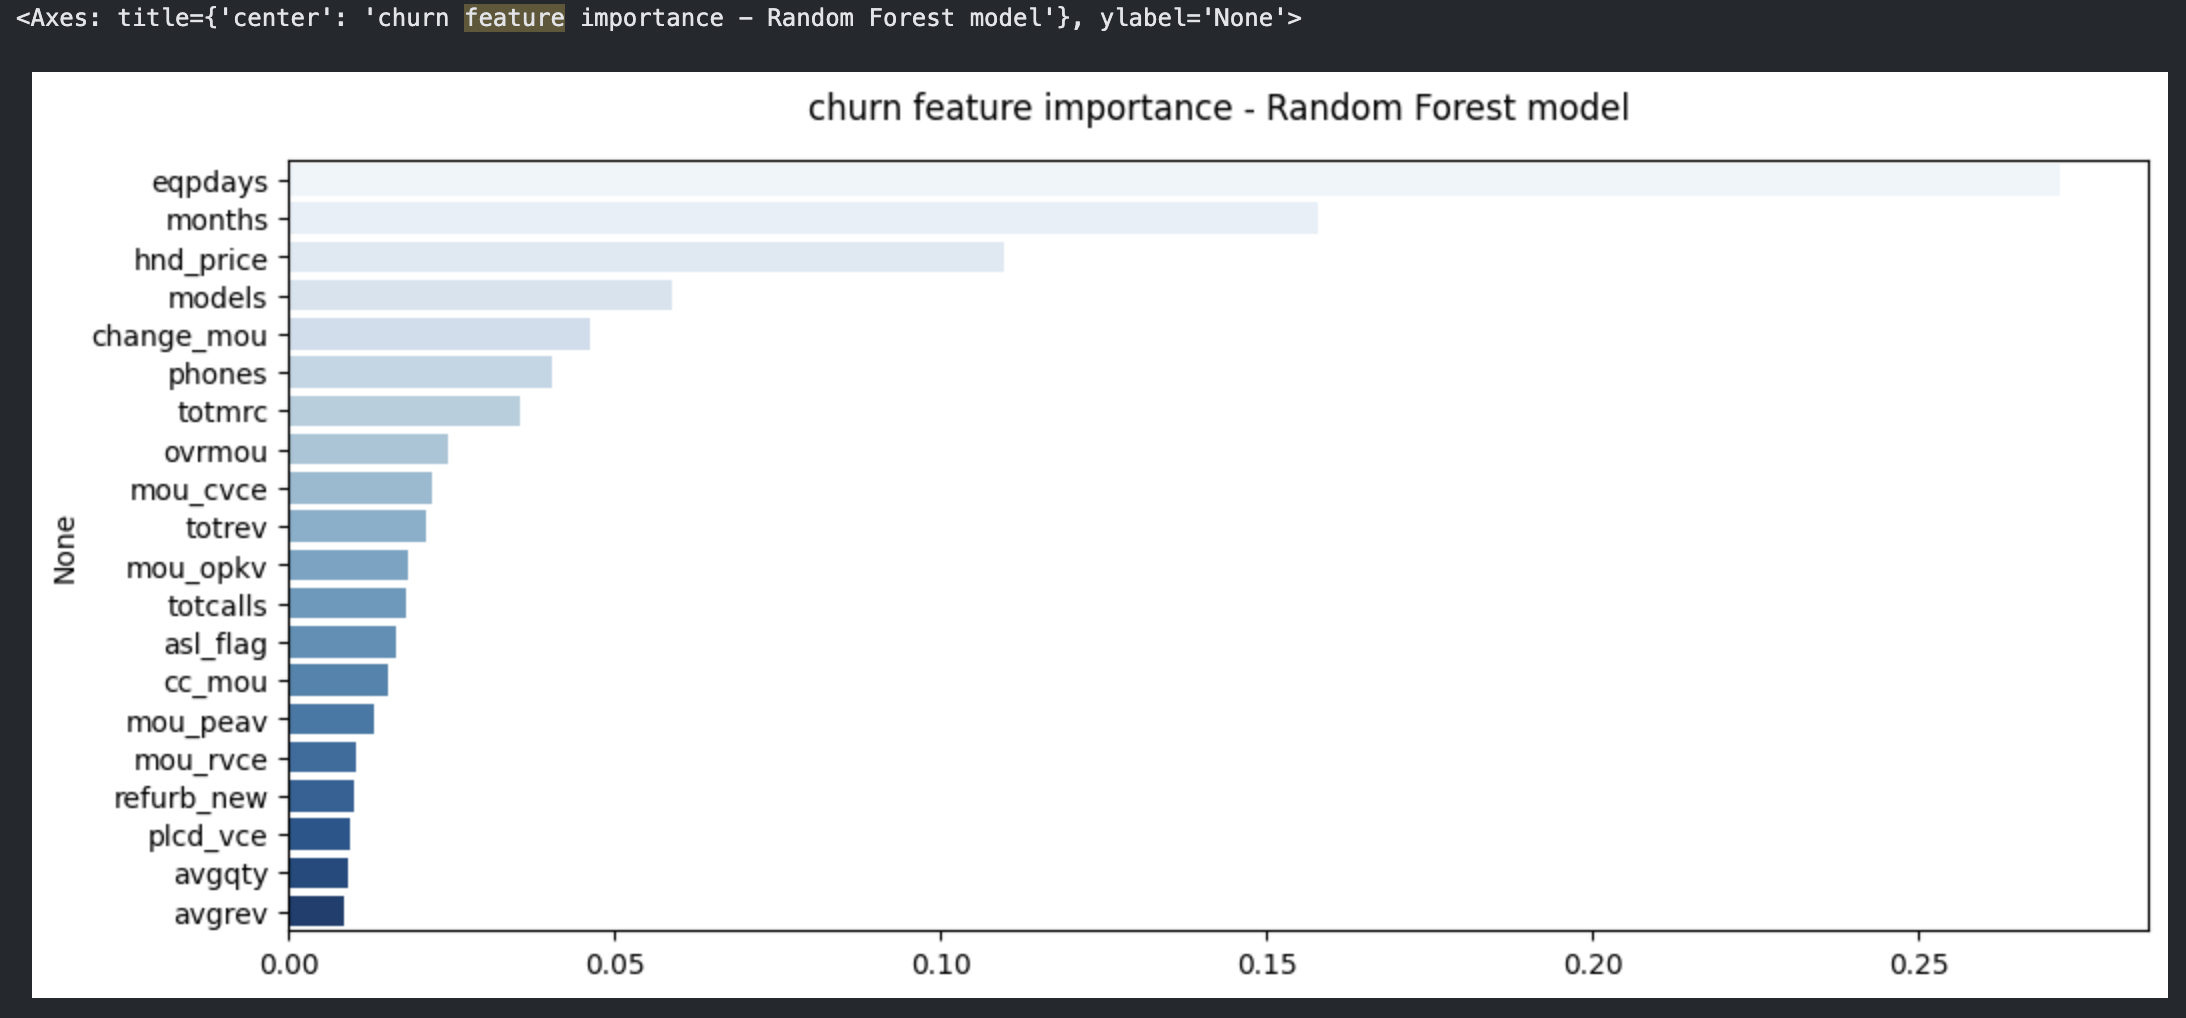

<Axes: title={'center': 'churn feature importance - CatBoost Classifier'}, ylabel='None'>

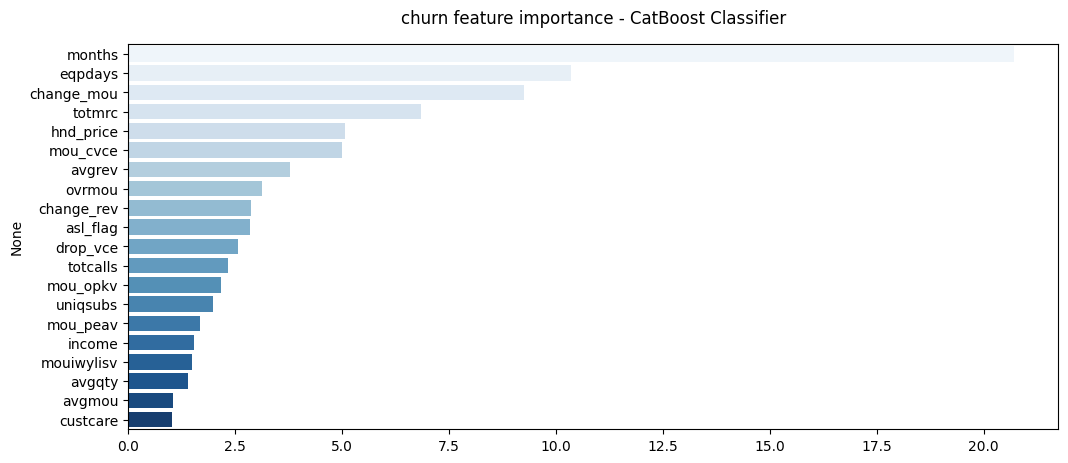

In [1427]:
params = {'random_state': 42, 'thread_count': 4, 'n_estimators': 100, 'max_depth': 4, 'verbose':False}

forest = CatBoostClassifier(**params)
x,y = df.drop(columns=target), df[target]
forest.fit(x,y)
best_features = forest.feature_importances_
columns = x.columns
imp = pd.Series(data=best_features, index=columns).sort_values(ascending=False)#[:20]

plt.figure(figsize=(12,5))
plt.title(f'{target} feature importance - CatBoost Classifier', pad=15)
sns.barplot(x=imp.values[:20], y=imp.index[:20], palette='Blues', orient='h')


In [1428]:
print('Las 20 caracteristicas mas importantes:')
imp[:20]

Las 20 caracteristicas mas importantes:


months        20.703292
eqpdays       10.342345
change_mou     9.244452
totmrc         6.838013
hnd_price      5.057857
mou_cvce       5.001253
avgrev         3.790610
ovrmou         3.136306
change_rev     2.875092
asl_flag       2.848116
drop_vce       2.578728
totcalls       2.329734
mou_opkv       2.176905
uniqsubs       1.987468
mou_peav       1.674316
income         1.541459
mouiwylisv     1.491970
avgqty         1.410514
avgmou         1.050953
custcare       1.032643
dtype: float64

In [1429]:
df_imp = imp.reset_index(name='importance')
df_imp['cumsum'] = df_imp['importance'].cumsum()
df_imp = df_imp[df_imp['importance']==0]
df_imp

index  importance  cumsum
63               crclscod_BA         0.0   100.0
64                  ethnic_U         0.0   100.0
65                  ethnic_S         0.0   100.0
66                 marital_M         0.0   100.0
67                 marital_B         0.0   100.0
68                 marital_A         0.0   100.0
69               lor_Unknown         0.0   100.0
70                   lor_7-9         0.0   100.0
71                   lor_4-6         0.0   100.0
72                 lor_10-12         0.0   100.0
73                  kid11_15         0.0   100.0
74                   lor_0-3         0.0   100.0
75           ownrent_Unknown         0.0   100.0
76                 ownrent_O         0.0   100.0
77                   opk_dat         0.0   100.0
78             hnd_webcap_WC         0.0   100.0
79                  mou_opkd         0.0   100.0
80                     truck         0.0   100.0
81                  forgntvl         0.0   100.0
82  prizm_social_one_Unknown         0.0   100.0
83        prizm_social_one_U         0.0   100.0
84        prizm_social_one_S         0.0   100.0
85        prizm_social_one_C         0.0   100.0
86                   kid6_10         0.0   100.0
87                        rv         0.0   100.0

In [1430]:
#cols a eliminar
cols_eliminar = df_imp['index'].to_list()

# eliminamos columnas sin importancia para el CatBoost
df.drop(columns=cols_eliminar, inplace=True)
df_pred.drop(columns=cols_eliminar, inplace=True)

print(f'num de columnas eliminadas: {len(cols_eliminar)}')
print(cols_eliminar)


num de columnas eliminadas: 25
['crclscod_BA', 'ethnic_U', 'ethnic_S', 'marital_M', 'marital_B', 'marital_A', 'lor_Unknown', 'lor_7-9', 'lor_4-6', 'lor_10-12', 'kid11_15', 'lor_0-3', 'ownrent_Unknown', 'ownrent_O', 'opk_dat', 'hnd_webcap_WC', 'mou_opkd', 'truck', 'forgntvl', 'prizm_social_one_Unknown', 'prizm_social_one_U', 'prizm_social_one_S', 'prizm_social_one_C', 'kid6_10', 'rv']


## Split train-test

In [1431]:
#df['months'] = pd.cut(df['months'], bins = [0, 10, 20, 30, 40, 50, np.inf], labels=[1,2,3,4,5,6])

In [1432]:
X = df.drop(columns=target)
y = df[target]

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8, stratify=X['months'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

## Rebalanceo del train

<Axes: xlabel='churn', ylabel='count'>

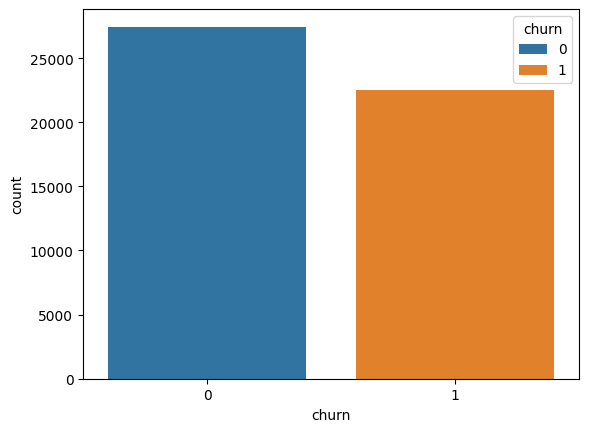

In [1433]:
sns.countplot(data=df, x=target, hue=target)

In [1434]:
# proporcion de cada clase de target
y_train.value_counts(normalize=True)

churn
0    0.549252
1    0.450748
Name: proportion, dtype: float64

In [1435]:
# Crear el undersampler
undersampler = RandomUnderSampler(sampling_strategy=1.0, replacement=False, random_state=42)  # 1.0 = igualar clases

# Aplicarlo solo al conjunto de entrenamiento
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [1436]:
# proporcion de cada clase de target despues de rebalancear el train
y_train.value_counts(normalize=True)

churn
0    0.5
1    0.5
Name: proportion, dtype: float64

## Estandarización

In [1437]:
escala = StandardScaler()

X_train = escala.fit_transform(X_train)
X_test = escala.transform(X_test)
X_pred = escala.transform(df_pred)

## Competición de modelos


Competir sobre el f1_score

In [1438]:
modelos = [
    ('LogisticRegression', LogisticRegression()),
    ('RidgeClassifier', RidgeClassifier()),
    ('SGDClassifier_logloss', SGDClassifier(loss='log_loss')),
    ('SGDClassifier_hinge', SGDClassifier(loss='hinge')),
    ('SGDClassifier_modifiedhuber', SGDClassifier(loss='modified_huber')),
    ('SVC_linear', SVC(kernel='linear')),
    ('SVC', SVC()),
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('RandomForestClassifier', RandomForestClassifier()),
    ('GradientBoostingClassifier', GradientBoostingClassifier()),
    ('XGBClassifier', XGBClassifier()),
    ('CatBoostClassifier', CatBoostClassifier(verbose=False))
]

In [1439]:
# metricas_modelos = pd.DataFrame(columns=['modelo', 'F1_score'])

# for nombre, modelo in modelos:

#     modelo.fit(X_train, y_train)
#     y_pred = modelo.predict(X_test)

#     score = f1_score(y_test, y_pred)

#     metricas_modelos = pd.concat([metricas_modelos,
#                                 pd.DataFrame({'modelo':nombre, 'F1_score':score}, index=[0])])

# metricas_modelos.sort_values(by='F1_score', ascending=False)



## Hiperparametrización

In [1440]:
# from sklearn.metrics import make_scorer

# # grid_params = {
# #     'depth': [6,8,10],
# #     'iterations' : [300, 600, 1000],
# #     'l2_leaf_reg': [3, 4, 5], 
# #     'loss_function': ['LogLoss', 'CrossEntropy'],
# #     'rsm': [0.8, 0.9, 1]
# # }

# grid_params = {
#     'depth': [8,10],
#     'iterations' : [600, 1000],
#     'l2_leaf_reg': [3, 4], 
#     'loss_function': ['LogLoss', 'CrossEntropy'],
#     'rsm': [0.8, 1]
# }

# modelo = CatBoostClassifier(random_state=42, verbose=False)

# f1_scorer = make_scorer(f1_score)

# grid_search = GridSearchCV(modelo, grid_params, scoring=f1_scorer, cv=3)
# grid_search.fit(X_train, y_train)

# print('Mejores parametros:', grid_search.best_params_)


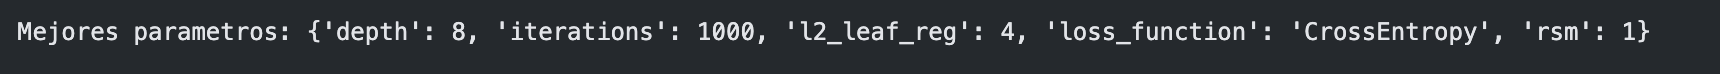

## Entrenamiento del modelo final

In [1441]:
# # best_params
# best_params = {
#     #'depth': 10,
#     'depth': 8,
#     #'iterations' : 1000,
#     #'l2_leaf_reg': 4, 
#     #'loss_function': 'CrossEntropy',
#     #'rsm': 1,
#     'verbose': False,
#     'random_state': 42
#     }

# # entrenamiento
# modelo = CatBoostClassifier(**best_params)
# modelo.fit(X_train, y_train)

In [1442]:
# entrenamiento
modelo = CatBoostClassifier(verbose=False, depth=6)
modelo.fit(X_train, y_train)

In [1443]:
# predict
y_test_pred = modelo.predict(X_test)

In [1444]:
# predict_proba
y_test_predict_proba = modelo.predict_proba(X_test)[:,1]

# Evaluación del modelo final

## AUC

Calcular el AUC con el predict_proba

In [1445]:
roc_auc_score(y_test, y_test_predict_proba)

0.9282837462324838

In [1446]:
roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1])

0.969474999297097

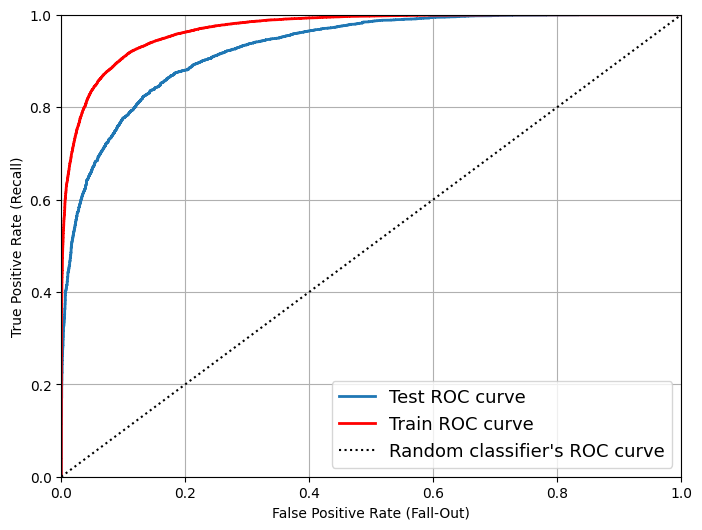

In [1447]:
# Visualizacion de la ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_test_predict_proba)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, modelo.predict_proba(X_train)[:,1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label="Test ROC curve")
plt.plot(fpr_train, tpr_train, linewidth=2, label="Train ROC curve", color='r')
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")

plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

## matriz de confusión

4595 verdaderos negativos
886 falsos positivos
667 falsos negativos
3852 verdaderos positivos


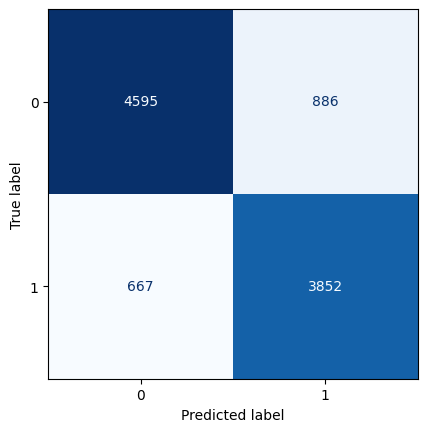

In [1448]:
cm = confusion_matrix(y_test, y_test_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cm_display.plot(colorbar=False, cmap='Blues')

VN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
VP = cm[1][1]

print(f'{VN} verdaderos negativos')
print(f'{FP} falsos positivos')
print(f'{FN} falsos negativos')
print(f'{VP} verdaderos positivos')

## f1_score

In [1449]:
modelo_score = f1_score(y_test, y_test_pred)
modelo_score

0.8322350653559468

# Guardar modelo

Guardar el modelo y lo que sea necesario para ejecutarlo (scaler)

In [1450]:
# with open('modelo.pkl', 'wb') as f:
#     pickle.dump(modelo, f)

# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(escala, f)

# with open('encoder.pkl', 'wb') as f:
#     pickle.dump(encoder, f)

# Interpretabilidad

## Modelo lineal

Si el mejor modelo ha sido un algoritmo basado en arbole de decisión, entrenamos el mejor modelo lineal de la competición de modelos, sin hiperparametrizar

Imprimir los coeficientes por variable + intercept

In [1451]:
# modelo_lineal = SVC(kernel='linear')
# modelo_lineal.fit(X_train, y_train)

In [1452]:
# print('intercept:', modelo_lineal.intercept_)

In [1453]:
# df_coeficientes = pd.DataFrame(columns=['variable','coeficiente'])

# for col, coef in zip(X.columns, modelo_lineal.coef_[0]):

#     df_coeficientes = pd.concat([df_coeficientes, pd.DataFrame({'variable':col, 'coeficiente':coef}, index=[0])])

# df_coeficientes.sort_values(by='coeficiente', ascending=False)

Imprimir los coeficientes de las 10 variables con mayor impacto (positivo o negativo)

In [1454]:
# df_coeficientes['coeficiente'] = np.abs(df_coeficientes['coeficiente'])
# top_10_coef = df_coeficientes.sort_values(by='coeficiente', ascending=False)[:10]
# top_10_coef

## Modelo de árbol de decisión

Si el mejor modelo ha sido un modelo lineal, entrenamos el mejor modelo basado en arboles de decisión, sin hiperparametrizar

&#x26a0;&#xfe0f;
El shap necesita el nombres de las variables. Estandarizar los datos los quita

### Shap values

In [1455]:
# creamos df_X_test
df_X_test = pd.DataFrame(X_test, columns=escala.get_feature_names_out())
df_X_test

rev    totmrc    ovrmou      roam  change_mou  change_rev  \
0     0.064059  0.986515 -0.119951 -0.157739    1.179912    0.584759   
1    -0.152904 -0.315322 -0.001515 -0.157739   -0.305447   -0.224575   
2     0.985175  1.195744 -0.406565 -0.157739    0.584801    0.283411   
3     0.008172  0.151268 -0.098633 -0.157739    0.427072   -0.211270   
4    -0.471524 -0.057544 -0.356822 -0.157739    0.172577   -0.024559   
...        ...       ...       ...       ...         ...         ...   
9995 -0.390584 -0.266356 -0.231280 -0.002748   -0.179651   -0.246015   
9996 -1.169307 -1.727621 -0.406565 -0.157739    0.064199    0.034651   
9997 -0.602087 -0.683980 -0.406565 -0.157739    0.086456    0.003123   
9998  0.452965  0.686765  0.152451 -0.157739    0.967994    2.881479   
9999 -0.488761 -0.683980 -0.243124 -0.157739   -0.087723   -0.120532   

      drop_vce  blck_vce  blck_dat  unan_vce  ...  dualband_Y  \
0     0.077535 -0.278981 -0.027118 -0.135562  ...    0.589414   
1     0.488609 -0.307963 -0.027118  1.383331  ...    0.589414   
2     0.301757 -0.163051 -0.027118  1.256049  ...    0.589414   
3    -0.595132  0.648455 -0.027118 -0.644688  ...   -1.696601   
4    -0.557761 -0.192034 -0.027118  0.483875  ...    0.589414   
...        ...       ...       ...       ...  ...         ...   
9995 -0.483021 -0.365928 -0.027118 -0.602261  ...   -1.696601   
9996 -0.669872 -0.365928 -0.027118 -0.712572  ...    0.589414   
9997 -0.557761 -0.278981 -0.027118 -0.704086  ...   -1.696601   
9998 -0.483021 -0.192034 -0.027118 -0.576805  ...    0.589414   
9999 -0.520391 -0.365928 -0.027118 -0.704086  ...   -1.696601   

      hnd_webcap_Unknown  hnd_webcap_WCMB  lor_13-15  marital_S  marital_U  \
0              -0.339778         0.555118  -0.366215  -0.476582  -0.762146   
1              -0.339778         0.555118  -0.366215  -0.476582  -0.762146   
2              -0.339778         0.555118  -0.366215   2.098275  -0.762146   
3               2.943101        -1.801420  -0.366215  -0.476582   1.312084   
4              -0.339778        -1.801420  -0.366215  -0.476582  -0.762146   
...                  ...              ...        ...        ...        ...   
9995           -0.339778         0.555118  -0.366215  -0.476582   1.312084   
9996           -0.339778         0.555118  -0.366215  -0.476582  -0.762146   
9997            2.943101        -1.801420  -0.366215  -0.476582  -0.762146   
9998           -0.339778         0.555118   2.730637   2.098275  -0.762146   
9999           -0.339778         0.555118  -0.366215  -0.476582   1.312084   

      ethnic_G  ethnic_H  ethnic_N  ethnic_other  
0    -0.253050 -0.394125 -0.726064      2.617047  
1    -0.253050 -0.394125  1.377288     -0.382110  
2    -0.253050 -0.394125  1.377288     -0.382110  
3    -0.253050  2.537264 -0.726064     -0.382110  
4    -0.253050 -0.394125 -0.726064     -0.382110  
...        ...       ...       ...           ...  
9995 -0.253050 -0.394125 -0.726064     -0.382110  
9996 -0.253050 -0.394125  1.377288     -0.382110  
9997 -0.253050 -0.394125  1.377288     -0.382110  
9998  3.951783 -0.394125 -0.726064     -0.382110  
9999 -0.253050 -0.394125 -0.726064     -0.382110  

[10000 rows x 63 columns]

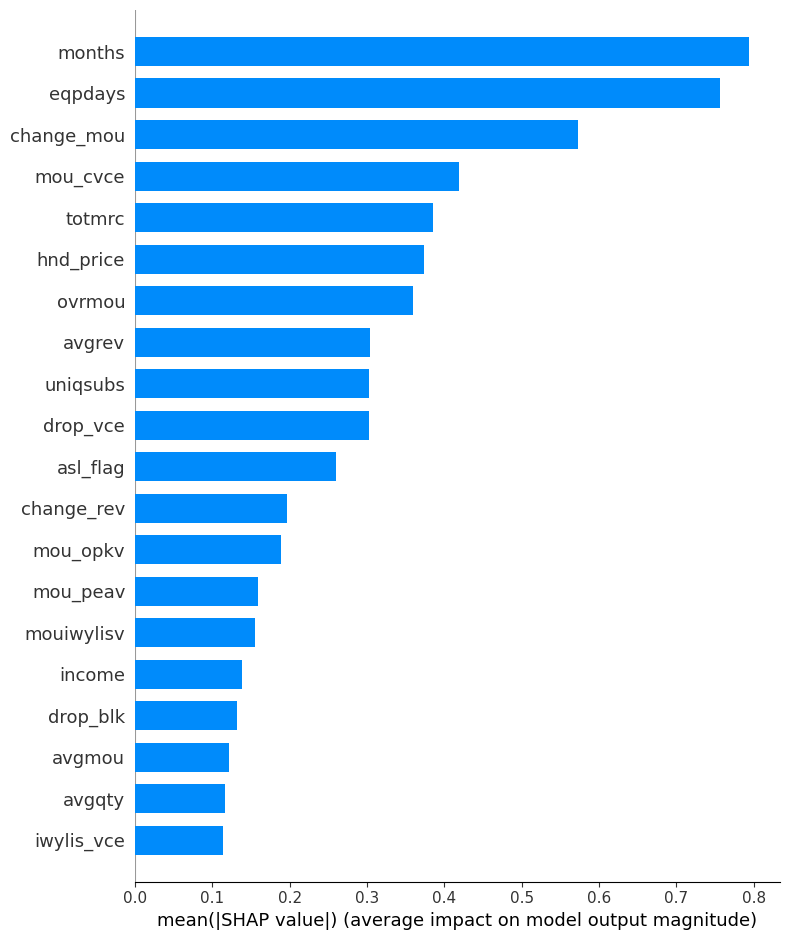

In [1456]:
#SHAP value: peso en el output final
explainer = shap.TreeExplainer(modelo)
shap_values = explainer.shap_values(df_X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, df_X_test, plot_type="bar", max_display=20)

### Summary_plot

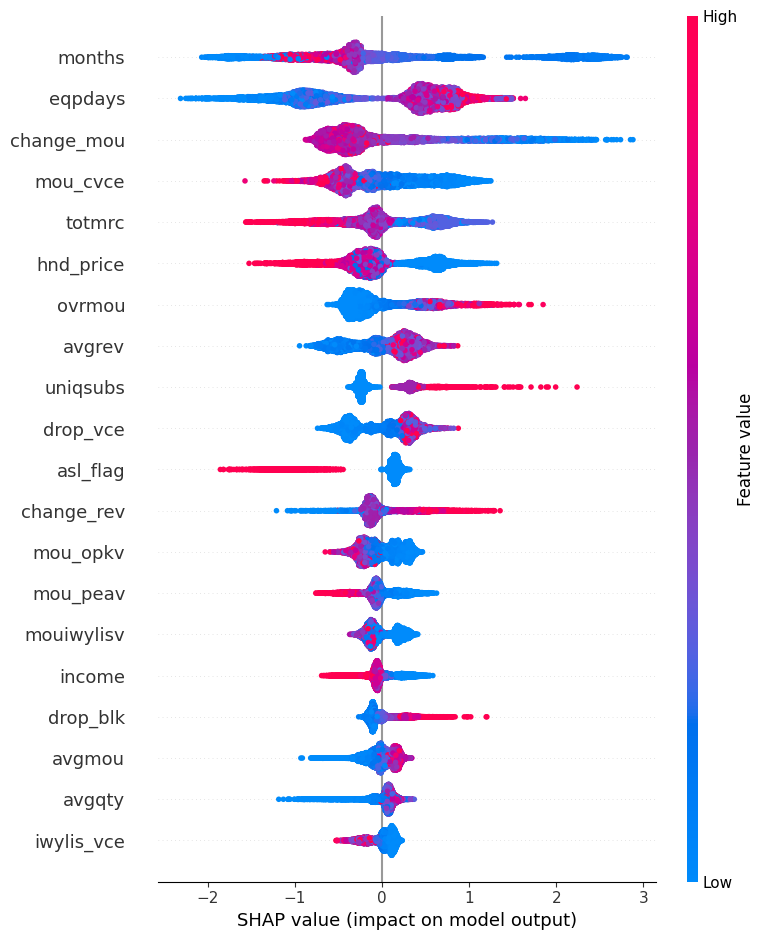

In [1457]:
shap.summary_plot(shap_values, df_X_test)

## Interpretabilidad top 5 variables

Explicar muy brevemente cuales son las 5 variables que más impactan en el churn, y si el impacto es positivo o negativo.

Variables mas importantes: 
- months: impacto negativo. En general los clientes con months bajos tienen mas probabilidad de churn = 1. Los clientes con months altos estan algo mas dispersos, vemos que en algunos casos el hecho de que los months sean mas altos aumentan la probabilidad de churn = 1, lo que puede estar relacionado con el final de ciertas promociones, o que la compania lleva tiempo sin hacer engagement con estos clientes

- eqpdays: impacto positivo. Los valores muy altos tienen mas probabilidad de churn = 1
- change_mou: impacto negativo. A menor uso mensual con respecto a los ultimos 3 meses, mayor probabilidad de churn=1
- mou_cvce: impacto negativo. A menor numero de minutos en llamada, mayor probabilidad de churn=1
- totmrc: impacto negativo. A menor recarga de saldo mensual, mayor probabilidad de churn=1

# Predicción

&#x26a0;&#xfe0f;
Realizar la predicción sobre el 100% de los clientes a predecir.  


&#x26a0;&#xfe0f;
Asegurarse de hacer la predicción en las mismas condiciones que el entrenamiento

In [1458]:
# entrenamos el modelo con el 100% de nuestros datos
X_total = escala.transform(X)
modelo.fit(X_total, y)

In [1459]:
predicciones = modelo.predict(X_pred)
predicciones

array([1, 0, 0, ..., 0, 0, 1])

Imprimir los 20 clientes más propensos a irse

In [1460]:
modelo.predict_proba(X_pred)[:,1]

array([0.99593389, 0.45723984, 0.20863779, ..., 0.00426077, 0.00689563,
       0.6924567 ])

In [1461]:
df_top_20_pred = pd.DataFrame({'customer_id': customer_id_pred, 'predict': predicciones, 'predict_proba': modelo.predict_proba(X_pred)[:,1]}).sort_values(by='predict_proba', ascending=False)[:20]
df_top_20_pred

customer_id  predict  predict_proba
755       1044403        1       0.999490
1242      1074314        1       0.999347
181       1011100        1       0.999314
895       1053817        1       0.999050
952       1057740        1       0.998287
19        1001590        1       0.998172
1422      1085925        1       0.998154
1171      1069466        1       0.997921
1144      1068171        1       0.997836
1218      1072363        1       0.997786
1295      1077461        1       0.997710
884       1052984        1       0.997551
1058      1063840        1       0.997545
669       1038997        1       0.997377
987       1059671        1       0.997095
263       1015279        1       0.997060
1223      1072690        1       0.996988
1383      1083442        1       0.996685
598       1034676        1       0.996681
828       1049437        1       0.996352

Imprimir el len del archivo de predicción

In [1462]:
len(predicciones)

1500

# Exportar predicción

Exportar un archivo excel con solamente 3 columnas, llamadas 'customer_id', 'predict' y 'predict_proba', **en minúscula**

In [1463]:
df_predicciones_resultado = pd.DataFrame({'customer_id': customer_id_pred, 'predict': predicciones, 'predict_proba': modelo.predict_proba(X_pred)[:,1]}).sort_values(by='predict_proba', ascending=False)
df_predicciones_resultado

customer_id  predict  predict_proba
755       1044403        1       0.999490
1242      1074314        1       0.999347
181       1011100        1       0.999314
895       1053817        1       0.999050
952       1057740        1       0.998287
...           ...      ...            ...
1416      1085554        0       0.001095
1448      1087230        0       0.000950
1427      1086149        0       0.000686
1456      1087532        0       0.000593
1375      1083050        0       0.000296

[1500 rows x 3 columns]

In [1464]:
print('712 churn=1')

712 churn=1


In [1465]:
df_predicciones_resultado['predict'].value_counts()

predict
0    844
1    656
Name: count, dtype: int64

In [1466]:
df_predicciones_resultado.to_excel('df_predicciones_resultado.xlsx')